<a href="https://colab.research.google.com/github/HeroicKrishna160905/dallaman/blob/main/rom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dalla Man

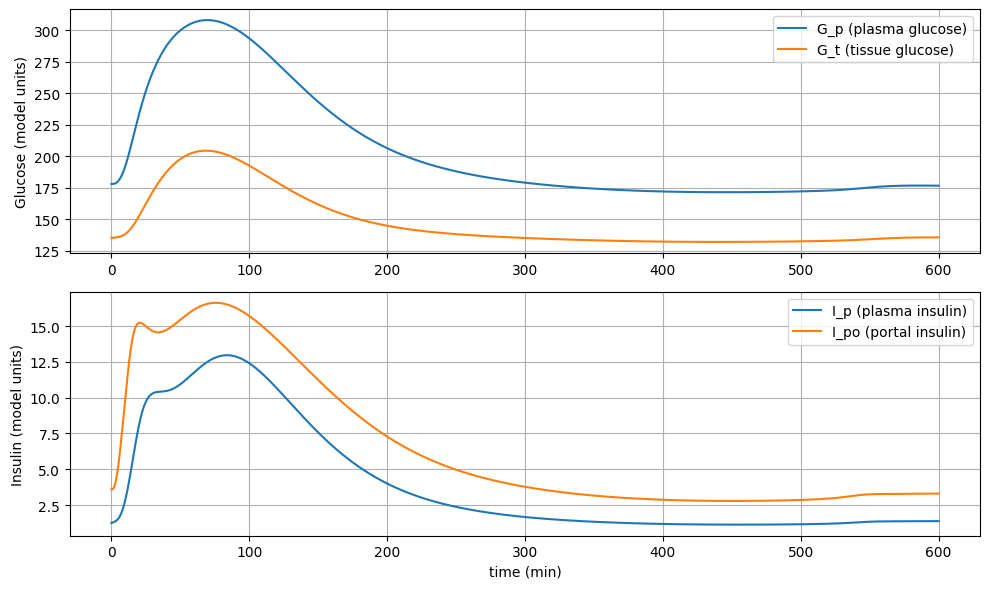

In [ ]:
"""
dallaman_openloop.py

Run with: python dallaman_openloop.py

Dependencies:
- numpy
- scipy
- matplotlib
"""
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def dallaman_ode(t, x, p):
    # x is vector of named states:
    # [Gp, Gt, Il, Ip, Qsto1, Qsto2, Qgut, I1, Id, X, I_po, Y]
    Gp, Gt, Il, Ip, Q_sto1, Q_sto2, Q_gut, I1, Id, X, I_po, Y = x

    # Unpack parameters
    V_G = p['V_G']
    k_1 = p['k_1']
    k_2 = p['k_2']
    G_b = p['G_b']
    V_I = p['V_I']
    m_1 = p['m_1']
    m_2 = p['m_2']
    m_4 = p['m_4']
    m_5 = p['m_5']
    m_6 = p['m_6']
    HE_b = p['HE_b']
    I_b = p['I_b']
    S_b = p['S_b']
    S_b_minus = p['S_b_minus']
    k_max = p['k_max']
    k_min = p['k_min']
    k_abs = p['k_abs']
    k_gri = p['k_gri']
    f = p['f']
    b = p['b']
    d = p['d']
    BW = p['BW']
    k_p1 = p['k_p1']
    k_p2 = p['k_p2']
    k_p3 = p['k_p3']
    k_p4 = p['k_p4']
    k_i = p['k_i']
    U_ii = p['U_ii']
    V_m0 = p['V_m0']
    V_mX = p['V_mX']
    K_m0 = p['K_m0']
    p_2U = p['p_2U']
    part = p['part']
    K = p['K']
    alpha = p['alpha']
    beta = p['beta']
    gamma = p['gamma']
    k_e1 = p['k_e1']
    k_e2 = p['k_e2']
    D = p['D']   # parameter used in gastric emptying scaling
    aa = 5/2/(1 - b) / D
    cc = 5/2 / d / D

    # Assign derived variables
    # EGP = k_p1 - k_p2*Gp - k_p3*Id - k_p4*I_po
    EGP = k_p1 - k_p2 * Gp - k_p3 * Id - k_p4 * I_po

    V_mmax = (1 - part) * (V_m0 + V_mX * X)
    U_idm = V_mmax * Gt / (K_m0 + Gt) if (K_m0 + Gt) != 0 else 0.0

    E = 0.0
    S = gamma * I_po
    I = Ip / V_I if V_I != 0 else 0.0
    G = Gp / V_G if V_G != 0 else 0.0

    HE = (-m_5) * S + m_6
    # prevent division by zero in m_3 computation if HE ~ 1:
    if abs(1 - HE) < 1e-8:
        m_3 = m_1 * 1e6
    else:
        m_3 = HE * m_1 / (1 - HE)

    Q_sto = Q_sto1 + Q_sto2
    Ra = f * k_abs * Q_gut / BW

    # gastric emptying nonlinear function (same tanh form as MATLAB)
    k_empt = k_min + (k_max - k_min) / 2.0 * (
        np.tanh(aa * (Q_sto - b * D)) - np.tanh(cc * (Q_sto - d * D)) + 2.0
    )

    U_id = U_idm
    U = U_ii + U_id

    # S_po as:
    S_po = Y + K * (EGP + Ra - E - U_ii - k_1 * Gp + k_2 * Gt) / V_G + S_b

    # Now the derivatives
    # dGp/dt
    dGp = EGP + Ra - E - U_ii - k_1 * Gp + k_2 * Gt
    # dGt/dt
    dGt = -U_id + k_1 * Gp - k_2 * Gt
    # dIl/dt
    dIl = (-m_1) * Il - m_3 * Il + m_2 * Ip + S
    # dIp/dt
    dIp = (-m_2) * Ip - m_4 * Ip + m_1 * Il
    # dQ_sto1/dt
    dQsto1 = -k_gri * Q_sto1
    # dQ_sto2/dt
    dQsto2 = -k_empt * Q_sto2 + k_gri * Q_sto1
    # dQ_gut/dt
    dQgut = -k_abs * Q_gut + k_empt * Q_sto2
    # dI1/dt
    dI1 = -k_i * (I1 - I)
    # dId/dt
    dId = -k_i * (Id - I1)
    # dX/dt
    dX = -p_2U * X + p_2U * (I - I_b)
    # dI_po/dt
    dIpo = -gamma * I_po + S_po
    # dY/dt
    dY = -alpha * (Y - beta * (G - G_b))

    return np.array([dGp, dGt, dIl, dIp, dQsto1, dQsto2, dQgut, dI1, dId, dX, dIpo, dY])

def run_simulation(t_span=(0, 600), dt=0.1):
    # parameters
    p = dict(
        V_G=1.88,
        k_1=0.065,
        k_2=0.079,
        G_b=95.0,
        V_I=0.05,
        m_1=0.19,
        m_2=0.484,
        m_4=0.194,
        m_5=0.0304,
        m_6=0.6471,
        HE_b=0.6,
        I_b=25.0,
        S_b=1.8,
        S_b_minus=-1.8,
        k_max=0.0558,
        k_min=0.008,
        k_abs=0.057,
        k_gri=0.0558,
        f=0.9,
        b=0.82,
        d=0.01,
        BW=78.0,
        k_p1=2.7,
        k_p2=0.0021,
        k_p3=0.009,
        k_p4=0.0618,
        k_i=0.0079,
        U_ii=1.0,
        V_m0=2.5,
        V_mX=0.047,
        K_m0=225.59,
        p_2U=0.0331,
        part=0.2,
        K=2.3,
        alpha=0.05,
        beta=0.11,
        gamma=0.5,
        k_e1=5.0e-4,
        k_e2=339.0,
        D=78000.0
    )

    # initial states ( we use named 12 states)
    x0 = np.array([
        178.0,  # Gp
        135.0,  # Gt
        4.5,    # Il
        1.25,   # Ip
        78000.0,# Q_sto1
        0.0,    # Q_sto2
        0.0,    # Q_gut
        25.0,   # I1
        25.0,   # Id
        0.0,    # X
        3.6,    # I_po
        0.0     # Y
    ])

    t_eval = np.arange(t_span[0], t_span[1] + dt, dt)

    sol = solve_ivp(lambda t, x: dallaman_ode(t, x, p),
                    t_span, x0, t_eval=t_eval, method='RK45', atol=1e-6, rtol=1e-6)

    return sol, p, x0

def plot_solution(sol):
    t = sol.t
    Gp = sol.y[0, :]
    Gt = sol.y[1, :]
    Ip = sol.y[3, :]
    Ipo = sol.y[10, :]

    plt.figure(figsize=(10, 6))
    plt.subplot(2,1,1)
    plt.plot(t, Gp / 1.0, label='G_p (plasma glucose)')  # units as in SBML
    plt.plot(t, Gt / 1.0, label='G_t (tissue glucose)')
    plt.ylabel('Glucose (model units)')
    plt.legend()
    plt.grid(True)

    plt.subplot(2,1,2)
    plt.plot(t, Ip, label='I_p (plasma insulin)')
    plt.plot(t, Ipo, label='I_po (portal insulin)')
    plt.xlabel('time (min)')
    plt.ylabel('Insulin (model units)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    sol, p, x0 = run_simulation((0, 600), dt=0.5)  # simulate 10 hours
    plot_solution(sol)

# Test1 ROM

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# ============================================================
# TEST 1: Empirical Input–Output Energy Analysis (Nonlinear ROM)
# ============================================================

def test_input_output_energy():
    """
    Empirical controllability–observability energy analysis
    for nonlinear Dalla Man model.

    Does NOT modify original model.
    Uses physiologically meaningful inputs only.
    """

    # --------------------------------------------------------
    # Baseline model
    # --------------------------------------------------------
    _, p_base, x0 = run_simulation(t_span=(0, 1), dt=1.0)

    t_span = (0, 300)          # 5 hours
    t_eval = np.linspace(*t_span, 1200)

    n_states = len(x0)

    state_names = [
        'Gp', 'Gt', 'Il', 'Ip', 'Q_sto1', 'Q_sto2',
        'Q_gut', 'I1', 'Id', 'X', 'I_po', 'Y'
    ]

    # --------------------------------------------------------
    # 1️⃣ Insulin impulse experiment
    # --------------------------------------------------------
    def insulin_impulse(t):
        return 10.0 if 10 <= t <= 15 else p_base['U_ii']

    def ode_insulin(t, x):
        p = p_base.copy()
        p['U_ii'] = insulin_impulse(t)
        return dallaman_ode(t, x, p)

    sol_ins = solve_ivp(
        ode_insulin, t_span, x0, t_eval=t_eval,
        atol=1e-6, rtol=1e-6
    )

    # --------------------------------------------------------
    # 2️⃣ Meal impulse experiment
    # --------------------------------------------------------
    def meal_impulse(t):
        return 1e4 if 10 <= t <= 15 else 0.0  # small meal impulse

    def ode_meal(t, x):
        p = p_base.copy()
        p['D'] = p_base['D'] + meal_impulse(t)
        return dallaman_ode(t, x, p)

    sol_meal = solve_ivp(
        ode_meal, t_span, x0, t_eval=t_eval,
        atol=1e-6, rtol=1e-6
    )

    # --------------------------------------------------------
    # 3️⃣ Empirical controllability energy
    # --------------------------------------------------------
    Wc = np.zeros(n_states)

    for i in range(n_states):
        Wc[i] = (
            np.trapz(sol_ins.y[i]**2, t_eval) +
            np.trapz(sol_meal.y[i]**2, t_eval)
        )

    # --------------------------------------------------------
    # 4️⃣ Empirical observability energy
    # --------------------------------------------------------
    glucose = sol_ins.y[0]  # Gp output
    Wo = np.zeros(n_states)

    for i in range(n_states):
        Wo[i] = np.trapz((sol_ins.y[i] * glucose)**2, t_eval)

    # --------------------------------------------------------
    # 5️⃣ Joint state influence
    # --------------------------------------------------------
    influence = np.sqrt(Wc * Wo)
    influence /= np.max(influence)

    ranked_idx = np.argsort(influence)[::-1]

    # --------------------------------------------------------
    # 6️⃣ Print results
    # --------------------------------------------------------
    print("\n" + "="*70)
    print("TEST 1 — Empirical Input–Output Energy Ranking")
    print("="*70)
    print(f"{'Rank':<5} {'State':<8} {'Influence':<10}")
    print("-"*40)

    for r, idx in enumerate(ranked_idx):
        print(f"{r+1:<5} {state_names[idx]:<8} {influence[idx]:.4f}")

    # --------------------------------------------------------
    # 7️⃣ Plot
    # --------------------------------------------------------
    plt.figure(figsize=(10, 5))
    plt.bar(
        range(n_states),
        influence[ranked_idx]
    )
    plt.xticks(
        range(n_states),
        [state_names[i] for i in ranked_idx],
        rotation=45
    )
    plt.ylabel("Normalized Influence")
    plt.title("State Importance for ROM (Empirical Energy)")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    return influence, ranked_idx


/tmp/ipython-input-2170053508.py:72: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  np.trapz(sol_ins.y[i]**2, t_eval) +
/tmp/ipython-input-2170053508.py:73: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  np.trapz(sol_meal.y[i]**2, t_eval)
/tmp/ipython-input-2170053508.py:83: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  Wo[i] = np.trapz((sol_ins.y[i] * glucose)**2, t_eval)



TEST 1 — Empirical Input–Output Energy Ranking
Rank  State    Influence 
----------------------------------------
1     Q_sto2   1.0000
2     Q_sto1   0.1912
3     Q_gut    0.0342
4     Gp       0.0001
5     Gt       0.0000
6     X        0.0000
7     I1       0.0000
8     Id       0.0000
9     Il       0.0000
10    I_po     0.0000
11    Ip       0.0000
12    Y        0.0000


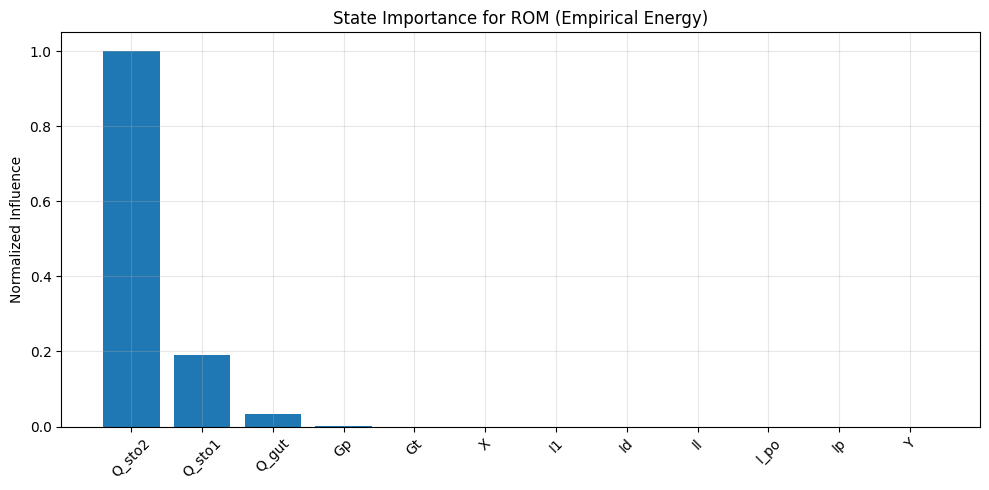

In [ ]:
influence, ranked_idx = test_input_output_energy()


# test 2

TEST 2 — Time-Scale Separation Analysis

Early Postprandial (30 min):
  Fastest τ ≈ 1.17e+00 min
  Slowest τ ≈ 1.21e+02 min
  Separation ratio ≈ 1.04e+02

Peak Glucose:
  Fastest τ ≈ 1.17e+00 min
  Slowest τ ≈ 1.22e+02 min
  Separation ratio ≈ 1.04e+02

Recovery (180 min):
  Fastest τ ≈ 1.15e+00 min
  Slowest τ ≈ 1.26e+02 min
  Separation ratio ≈ 1.10e+02


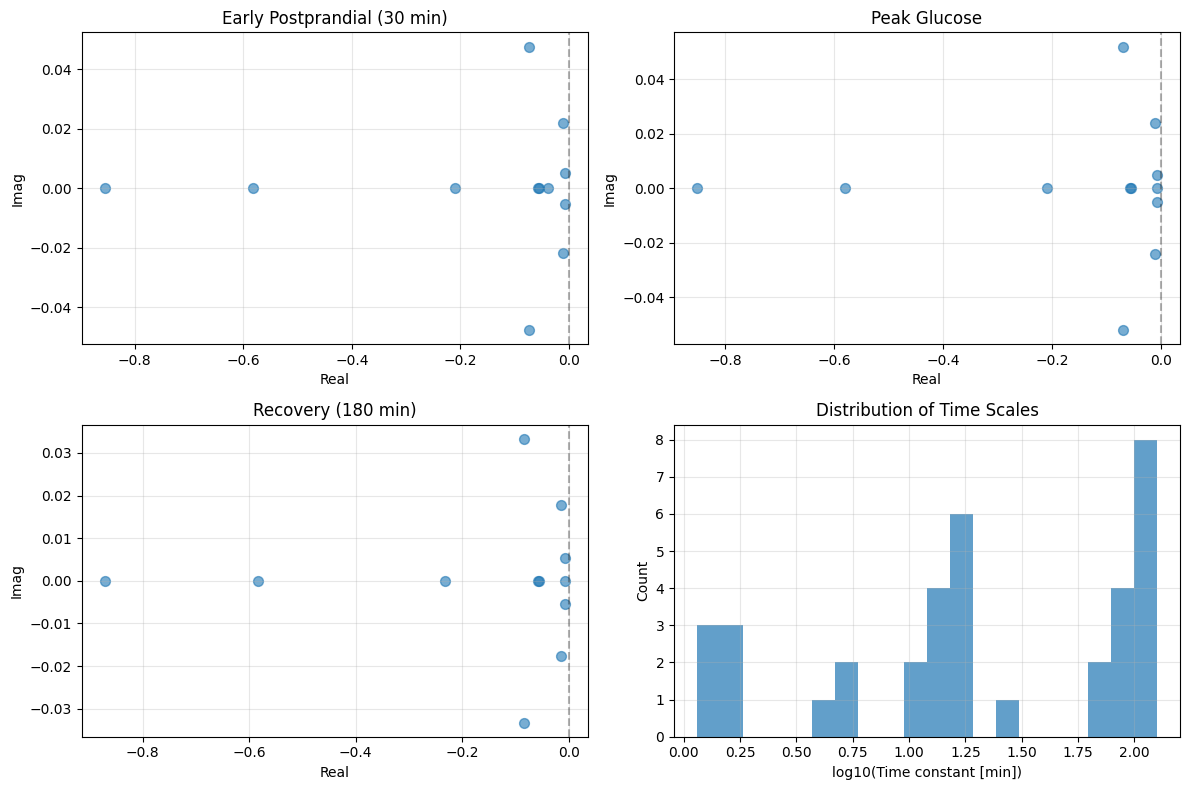


STATE-BY-STATE CHARACTERISTIC TIME SCALE
----------------------------------------------------------------------
Gp     : τ ≈    61.78 min
Gt     : τ ≈    59.78 min
Il     : τ ≈     2.53 min
Ip     : τ ≈     1.57 min
Q_sto1 : τ ≈    17.92 min
Q_sto2 : τ ≈    17.98 min
Q_gut  : τ ≈    17.83 min
I1     : τ ≈    72.36 min
Id     : τ ≈   131.05 min
X      : τ ≈    15.19 min
I_po   : τ ≈     2.15 min
Y      : τ ≈    61.18 min


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from numpy.linalg import eig




# ============================================================
# TEST 2: Time-Scale Separation Analysis (Trajectory-Based)
# ============================================================

def test_time_scale_separation():

    print("="*70)
    print("TEST 2 — Time-Scale Separation Analysis")
    print("="*70)

    # --------------------------------------------------------
    # Load baseline model
    # --------------------------------------------------------
    _, p_base, x0 = run_simulation(t_span=(0, 1), dt=1.0)

    t_span = (0, 300)
    t_eval = np.linspace(*t_span, 1200)

    # --------------------------------------------------------
    # Simulate baseline trajectory (no extra inputs)
    # --------------------------------------------------------
    sol = solve_ivp(
        lambda t, x: dallaman_ode(t, x, p_base),
        t_span, x0, t_eval=t_eval,
        atol=1e-6, rtol=1e-6
    )

    # --------------------------------------------------------
    # Helper: finite-difference Jacobian
    # --------------------------------------------------------
    def compute_jacobian(x, p, t):
        n = len(x)
        J = np.zeros((n, n))
        f0 = dallaman_ode(t, x, p)
        eps = 1e-6

        for i in range(n):
            x_pert = x.copy()
            x_pert[i] += eps
            f_pert = dallaman_ode(t, x_pert, p)
            J[:, i] = (f_pert - f0) / eps

        return J

    # --------------------------------------------------------
    # Select meaningful operating points
    # --------------------------------------------------------
    sample_points = {
        "Early Postprandial (30 min)": np.searchsorted(t_eval, 30),
        "Peak Glucose": np.argmax(sol.y[0]),
        "Recovery (180 min)": np.searchsorted(t_eval, 180),
    }

    results = {}
    all_time_constants = []

    plt.figure(figsize=(12, 8))

    for k, (label, idx) in enumerate(sample_points.items()):
        x_pt = sol.y[:, idx]
        t_pt = t_eval[idx]

        J = compute_jacobian(x_pt, p_base, t_pt)
        eigvals, eigvecs = eig(J)

        # Only stable modes
        stable = np.real(eigvals) < 0
        taus = -1 / np.real(eigvals[stable])

        results[label] = taus
        all_time_constants.extend(taus)

        plt.subplot(2, 2, k + 1)
        plt.scatter(np.real(eigvals), np.imag(eigvals), s=50, alpha=0.6)
        plt.axvline(0, color='k', linestyle='--', alpha=0.3)
        plt.xlabel("Real")
        plt.ylabel("Imag")
        plt.title(label)
        plt.grid(alpha=0.3)

        print(f"\n{label}:")
        print(f"  Fastest τ ≈ {np.min(taus):.2e} min")
        print(f"  Slowest τ ≈ {np.max(taus):.2e} min")
        print(f"  Separation ratio ≈ {np.max(taus)/np.min(taus):.2e}")

    # --------------------------------------------------------
    # Global time-scale histogram
    # --------------------------------------------------------
    plt.subplot(2, 2, 4)
    log_tau = np.log10(np.array(all_time_constants))
    plt.hist(log_tau, bins=20, alpha=0.7)
    plt.xlabel("log10(Time constant [min])")
    plt.ylabel("Count")
    plt.title("Distribution of Time Scales")
    plt.grid(alpha=0.3)

    # Identify spectral gap
    log_tau_sorted = np.sort(log_tau)
    gaps = np.diff(log_tau_sorted)
    gap_idx = np.argmax(gaps)

    if gaps[gap_idx] > 1.0:
        threshold = 10 ** ((log_tau_sorted[gap_idx] +
                            log_tau_sorted[gap_idx + 1]) / 2)
        plt.axvline(np.log10(threshold), color='r', linestyle='--')
        print("\n" + "="*70)
        print("TIME-SCALE SPLITTING RECOMMENDATION")
        print(f"Natural separation at τ ≈ {threshold:.1f} min")
        print("FAST  modes: τ below threshold")
        print("SLOW  modes: τ above threshold")

    plt.tight_layout()
    plt.show()

    # --------------------------------------------------------
    # State-wise characteristic time scale (basal Jacobian)
    # --------------------------------------------------------
    J0 = compute_jacobian(sol.y[:, 0], p_base, t_eval[0])
    eigvals, eigvecs = eig(J0)

    state_names = [
        'Gp', 'Gt', 'Il', 'Ip', 'Q_sto1', 'Q_sto2',
        'Q_gut', 'I1', 'Id', 'X', 'I_po', 'Y'
    ]

    state_tau = np.zeros(len(state_names))

    for i in range(len(state_names)):
        participation = np.abs(eigvecs[i])**2
        participation /= participation.sum()

        taus = np.where(np.real(eigvals) < 0, -1/np.real(eigvals), np.inf)
        valid = taus < np.inf

        state_tau[i] = np.exp(
            np.sum(participation[valid] * np.log(taus[valid]))
        )

    print("\n" + "="*70)
    print("STATE-BY-STATE CHARACTERISTIC TIME SCALE")
    print("-"*70)

    for name, tau in zip(state_names, state_tau):
        print(f"{name:7s}: τ ≈ {tau:8.2f} min")

    return results, state_tau


# ------------------------------------------------------------
# Run Test 2
# ------------------------------------------------------------
if __name__ == "__main__":
    time_scale_results, state_time_constants = test_time_scale_separation()


# test 3

TEST 3 — Excitation-Rich Identifiability Analysis

FISHER INFORMATION SUMMARY
----------------------------------------
Standard experiment condition #: 7.82e+05
Designed experiment condition #: 5.57e+10
Condition number improvement: -7125918.3%
→ Non-identifiability is structural


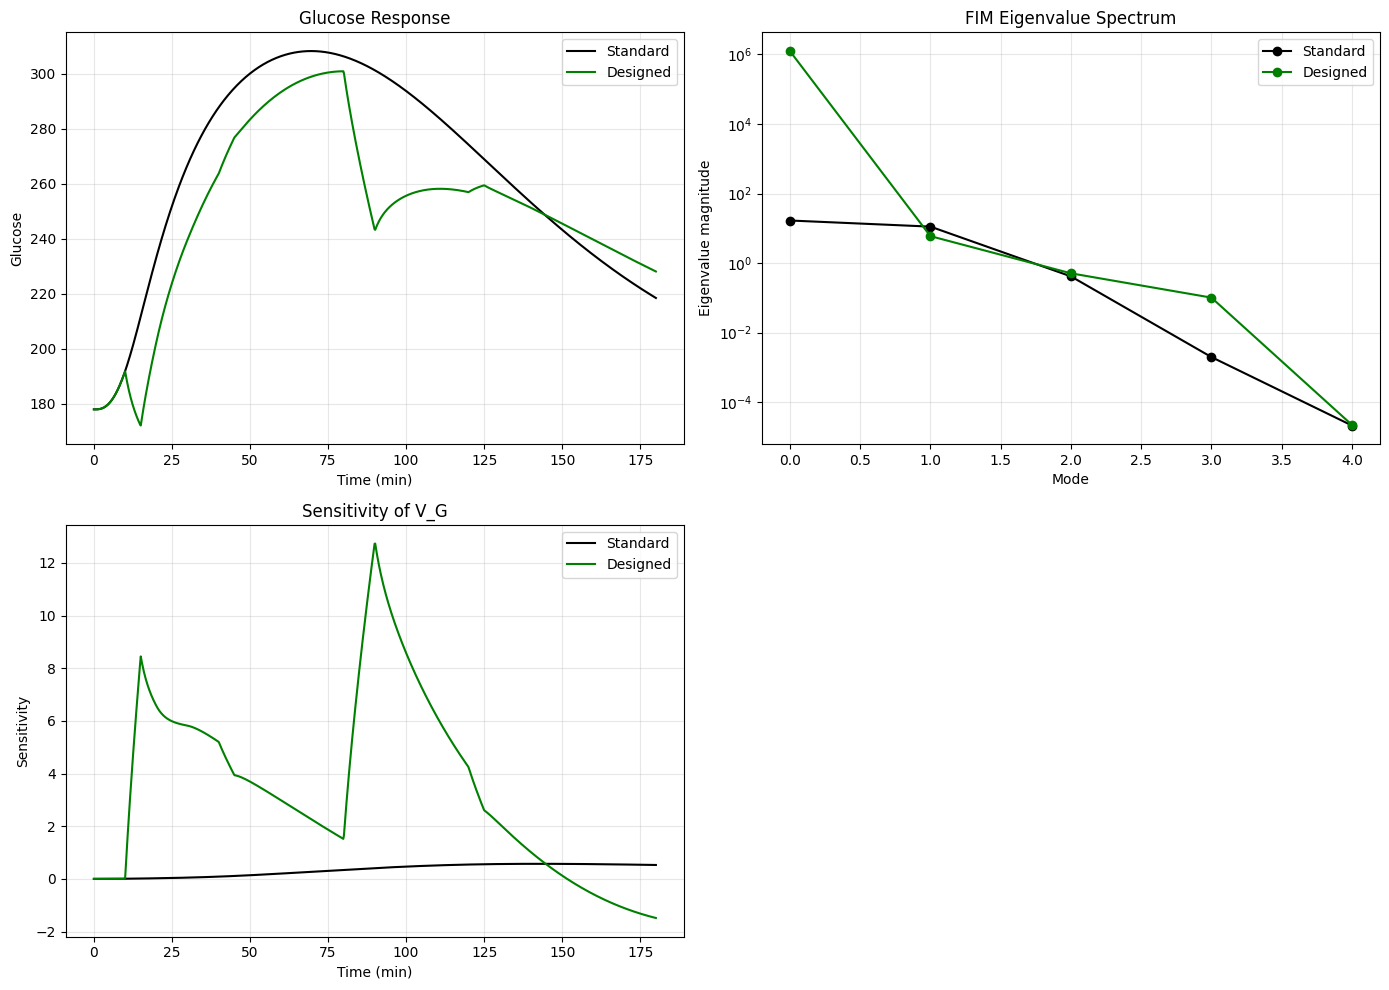

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp


# ============================================================
# TEST 3: Excitation-Rich Experiment (Identifiability Check)
# ============================================================

def test_excitation_rich_experiment():

    print("="*70)
    print("TEST 3 — Excitation-Rich Identifiability Analysis")
    print("="*70)

    # --------------------------------------------------------
    # Load baseline model
    # --------------------------------------------------------
    _, p_base, x0 = run_simulation(t_span=(0, 1), dt=1.0)

    t_span = (0, 180)
    t_eval = np.linspace(*t_span, 900)

    # --------------------------------------------------------
    # Designed (information-rich) excitation
    # --------------------------------------------------------
    def insulin_profile(t):
        # multi-pulse insulin infusion (physically realizable)
        pulses = [(10, 5, 10), (40, 5, -5), (80, 10, 8), (120, 5, -4)]
        u = p_base['U_ii']
        for start, dur, amp in pulses:
            if start <= t < start + dur:
                u += amp
        return max(u, 0.0)

    def meal_profile(t):
        # split meal excitation (carb loads)
        meals = [(20, 10, 8000), (60, 10, 4000), (100, 15, 6000)]
        D = p_base['D']
        for start, dur, amp in meals:
            if start <= t < start + dur:
                D += amp
        return D

    # --------------------------------------------------------
    # Designed experiment simulation
    # --------------------------------------------------------
    def ode_designed(t, x):
        p = p_base.copy()
        p['U_ii'] = insulin_profile(t)
        p['D'] = meal_profile(t)
        return dallaman_ode(t, x, p)

    sol_designed = solve_ivp(
        ode_designed, t_span, x0, t_eval=t_eval,
        atol=1e-6, rtol=1e-6
    )

    # --------------------------------------------------------
    # Standard experiment (single meal, basal insulin)
    # --------------------------------------------------------
    sol_standard = solve_ivp(
        lambda t, x: dallaman_ode(t, x, p_base),
        t_span, x0, t_eval=t_eval,
        atol=1e-6, rtol=1e-6
    )

    # --------------------------------------------------------
    # Fisher Information Matrix (empirical)
    # --------------------------------------------------------
    def compute_fim(sol, params):
        eps = 0.01  # 1% perturbation
        n_params = len(params)
        n_time = len(sol.t)

        S = np.zeros((n_time, n_params))
        y_nom = sol.y[0]  # plasma glucose

        for i, param in enumerate(params):
            p_pert = p_base.copy()
            p_pert[param] *= (1 + eps)

            sol_pert = solve_ivp(
                lambda t, x: dallaman_ode(t, x, p_pert),
                t_span, x0, t_eval=sol.t,
                atol=1e-6, rtol=1e-6
            )

            y_pert = sol_pert.y[0]
            S[:, i] = (y_pert - y_nom) / (eps * p_base[param])

        # normalize sensitivities
        S = S / np.mean(np.abs(y_nom))

        FIM = S.T @ S / n_time
        eigvals = np.linalg.eigvals(FIM)

        return FIM, eigvals, S

    params = ['V_G', 'k_1', 'k_p1', 'k_abs', 'k_i']

    FIM_std, eig_std, S_std = compute_fim(sol_standard, params)
    FIM_des, eig_des, S_des = compute_fim(sol_designed, params)

    # --------------------------------------------------------
    # Diagnostics
    # --------------------------------------------------------
    def condition_number(eigs):
        eigs = np.real(eigs)
        eigs = eigs[eigs > 1e-10]
        return np.max(eigs) / np.min(eigs)

    cond_std = condition_number(eig_std)
    cond_des = condition_number(eig_des)

    print("\nFISHER INFORMATION SUMMARY")
    print("-"*40)
    print(f"Standard experiment condition #: {cond_std:.2e}")
    print(f"Designed experiment condition #: {cond_des:.2e}")

    improvement = (cond_std - cond_des) / cond_std * 100
    print(f"Condition number improvement: {improvement:.1f}%")

    if improvement > 50:
        print("→ Identifiability was excitation-limited")
    elif improvement > 10:
        print("→ Partial excitation limitation")
    else:
        print("→ Non-identifiability is structural")

    # --------------------------------------------------------
    # Plots
    # --------------------------------------------------------
    plt.figure(figsize=(14, 10))

    plt.subplot(2, 2, 1)
    plt.plot(t_eval, sol_standard.y[0], 'k', label='Standard')
    plt.plot(t_eval, sol_designed.y[0], 'g', label='Designed')
    plt.xlabel("Time (min)")
    plt.ylabel("Glucose")
    plt.title("Glucose Response")
    plt.legend()
    plt.grid(alpha=0.3)

    plt.subplot(2, 2, 2)
    plt.semilogy(np.sort(np.abs(eig_std))[::-1], 'ko-', label='Standard')
    plt.semilogy(np.sort(np.abs(eig_des))[::-1], 'go-', label='Designed')
    plt.title("FIM Eigenvalue Spectrum")
    plt.xlabel("Mode")
    plt.ylabel("Eigenvalue magnitude")
    plt.legend()
    plt.grid(alpha=0.3)

    plt.subplot(2, 2, 3)
    plt.plot(t_eval, S_std[:, 0], 'k', label='Standard')
    plt.plot(t_eval, S_des[:, 0], 'g', label='Designed')
    plt.title("Sensitivity of V_G")
    plt.xlabel("Time (min)")
    plt.ylabel("Sensitivity")
    plt.legend()
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    return FIM_std, FIM_des, improvement


# ------------------------------------------------------------
# Run Test 3
# ------------------------------------------------------------
if __name__ == "__main__":
    FIM_std, FIM_des, improvement = test_excitation_rich_experiment()


# test 4

TEST 4 — Output Map Sensitivity Analysis

STATE INFLUENCE ON GLUCOSE DYNAMICS (dGp/dt)
----------------------------------------------------------------------
Rank  State    Mean Sensitivity Role
----------------------------------------------------------------------
1     Gt       7.900e-02       Direct
2     Gp       6.710e-02       Direct
3     I_po     6.180e-02       Indirect
4     Id       9.000e-03       Indirect
5     Q_gut    6.577e-04       Indirect
6     Y        0.000e+00       Indirect
7     X        0.000e+00       Indirect
8     I1       0.000e+00       Indirect
9     Q_sto1   0.000e+00       Indirect
10    Q_sto2   0.000e+00       Indirect
11    Il       0.000e+00       Indirect
12    Ip       0.000e+00       Indirect

LOW-INFLUENCE STATES (Candidates for Elimination)
----------------------------------------------------------------------
  • Il
  • Ip
  • Q_sto1
  • Q_sto2
  • Q_gut
  • I1
  • X
  • Y


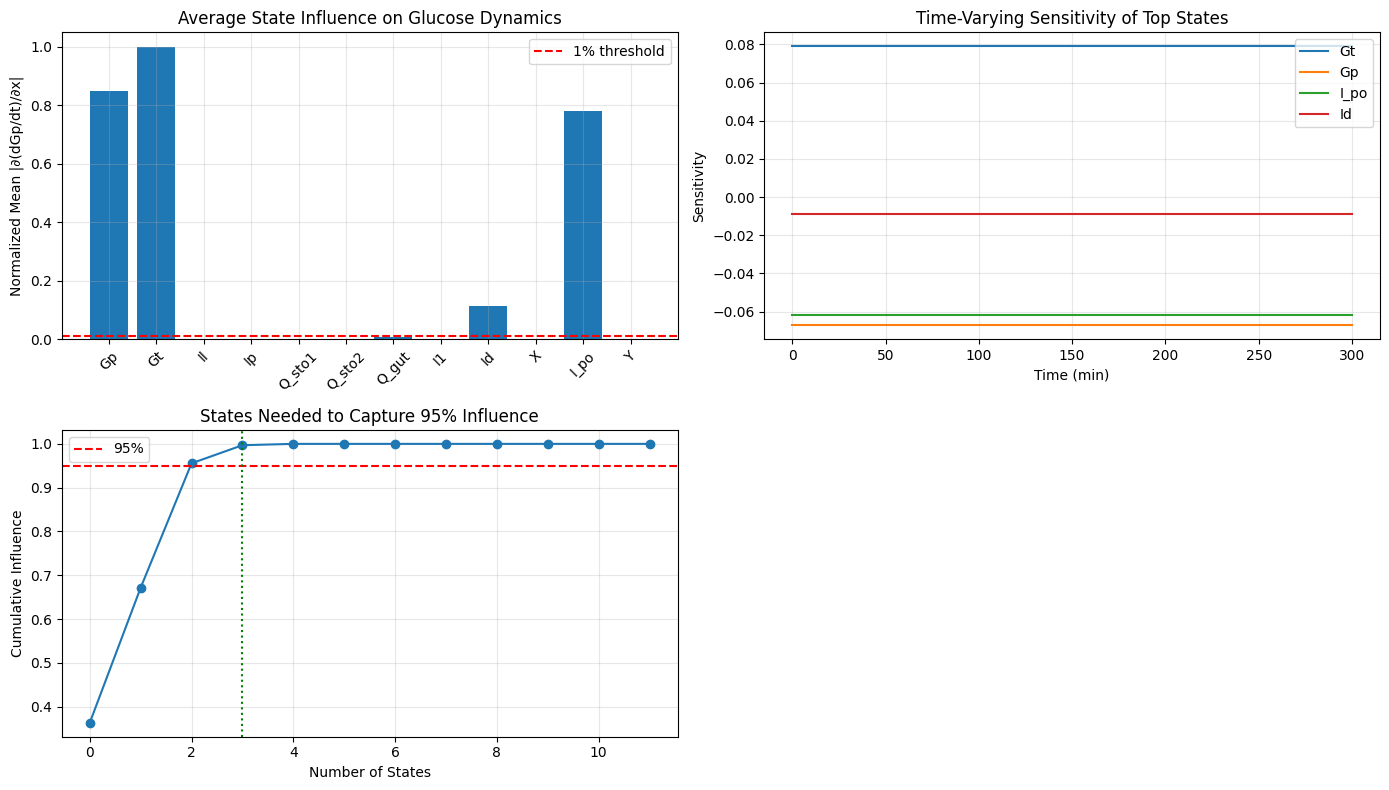


ROM DESIGN RECOMMENDATIONS (FROM TEST 4)
----------------------------------------------------------------------

• 3 states capture 95% of glucose dynamics influence
• Strong candidates for elimination:
  - Il
  - Ip
  - Q_sto1
  - Q_sto2
  - Q_gut
  - I1
  - X
  - Y

• Essential states (keep):
  - Gt
  - Gp
  - I_po
  - Id
  - Q_gut


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp




# ============================================================
# TEST 4: Output Map Sensitivity (Glucose Dynamics)
# ============================================================

def test_output_map_sensitivity():

    print("="*70)
    print("TEST 4 — Output Map Sensitivity Analysis")
    print("="*70)

    # --------------------------------------------------------
    # Load baseline model
    # --------------------------------------------------------
    _, p_base, x0 = run_simulation(t_span=(0, 1), dt=1.0)

    t_span = (0, 300)
    t_eval = np.linspace(*t_span, 1200)

    # --------------------------------------------------------
    # Baseline trajectory
    # --------------------------------------------------------
    sol = solve_ivp(
        lambda t, x: dallaman_ode(t, x, p_base),
        t_span, x0, t_eval=t_eval,
        atol=1e-6, rtol=1e-6
    )

    state_names = [
        'Gp', 'Gt', 'Il', 'Ip', 'Q_sto1', 'Q_sto2',
        'Q_gut', 'I1', 'Id', 'X', 'I_po', 'Y'
    ]

    n_states = len(state_names)

    # --------------------------------------------------------
    # Sensitivity of dGp/dt w.r.t. each state
    # --------------------------------------------------------
    n_points = 100
    indices = np.linspace(0, len(t_eval) - 1, n_points, dtype=int)

    sensitivities = np.zeros((n_states, n_points))
    eps = 1e-5

    for j, idx in enumerate(indices):
        t = t_eval[idx]
        x = sol.y[:, idx]

        dGp_nom = dallaman_ode(t, x, p_base)[0]

        for i in range(n_states):
            x_pert = x.copy()
            x_pert[i] += eps
            dGp_pert = dallaman_ode(t, x_pert, p_base)[0]
            sensitivities[i, j] = (dGp_pert - dGp_nom) / eps

    # --------------------------------------------------------
    # Aggregate metrics
    # --------------------------------------------------------
    mean_sens = np.mean(np.abs(sensitivities), axis=1)
    max_sens = np.max(np.abs(sensitivities), axis=1)

    mean_sens_norm = mean_sens / np.max(mean_sens)

    ranked_idx = np.argsort(mean_sens)[::-1]

    # --------------------------------------------------------
    # Print ranking
    # --------------------------------------------------------
    print("\nSTATE INFLUENCE ON GLUCOSE DYNAMICS (dGp/dt)")
    print("-"*70)
    print(f"{'Rank':<5} {'State':<8} {'Mean Sensitivity':<15} {'Role'}")
    print("-"*70)

    for r, i in enumerate(ranked_idx):
        role = "Direct" if state_names[i] in ['Gp', 'Gt'] else "Indirect"
        print(f"{r+1:<5} {state_names[i]:<8} {mean_sens[i]:<15.3e} {role}")

    # --------------------------------------------------------
    # Identify negligible states
    # --------------------------------------------------------
    threshold = 0.01 * np.max(mean_sens)
    dead_states = [
        state_names[i] for i in range(n_states)
        if mean_sens[i] < threshold
    ]

    print("\n" + "="*70)
    print("LOW-INFLUENCE STATES (Candidates for Elimination)")
    print("-"*70)

    if dead_states:
        for s in dead_states:
            print(f"  • {s}")
    else:
        print("  None — all states influence glucose non-negligibly")

    # --------------------------------------------------------
    # Plots
    # --------------------------------------------------------
    plt.figure(figsize=(14, 8))

    # Mean sensitivity bar plot
    plt.subplot(2, 2, 1)
    plt.bar(range(n_states), mean_sens_norm)
    plt.xticks(range(n_states), state_names, rotation=45)
    plt.ylabel("Normalized Mean |∂(dGp/dt)/∂x|")
    plt.title("Average State Influence on Glucose Dynamics")
    plt.grid(alpha=0.3)

    plt.axhline(threshold / np.max(mean_sens), color='r',
                linestyle='--', label='1% threshold')
    plt.legend()

    # Time-varying sensitivity of top states
    plt.subplot(2, 2, 2)
    for i in ranked_idx[:4]:
        plt.plot(t_eval[indices], sensitivities[i],
                 label=state_names[i])
    plt.xlabel("Time (min)")
    plt.ylabel("Sensitivity")
    plt.title("Time-Varying Sensitivity of Top States")
    plt.legend()
    plt.grid(alpha=0.3)

    # Cumulative influence
    plt.subplot(2, 2, 3)
    sorted_sens = np.sort(mean_sens)[::-1]
    cumulative = np.cumsum(sorted_sens) / np.sum(sorted_sens)
    plt.plot(cumulative, 'o-')
    plt.axhline(0.95, color='r', linestyle='--', label='95%')
    plt.xlabel("Number of States")
    plt.ylabel("Cumulative Influence")
    plt.title("States Needed to Capture 95% Influence")
    plt.legend()
    plt.grid(alpha=0.3)

    n_95 = np.argmax(cumulative >= 0.95) + 1
    plt.axvline(n_95, color='g', linestyle=':')

    plt.tight_layout()
    plt.show()

    # --------------------------------------------------------
    # ROM recommendations
    # --------------------------------------------------------
    print("\n" + "="*70)
    print("ROM DESIGN RECOMMENDATIONS (FROM TEST 4)")
    print("-"*70)

    print(f"\n• {n_95} states capture 95% of glucose dynamics influence")
    print("• Strong candidates for elimination:")
    for s in dead_states:
        print(f"  - {s}")

    print("\n• Essential states (keep):")
    for i in ranked_idx[:5]:
        print(f"  - {state_names[i]}")

    return sensitivities, mean_sens, dead_states


# ------------------------------------------------------------
# Run Test 4
# ------------------------------------------------------------
if __name__ == "__main__":
    sensitivities, mean_sens, dead_states = test_output_map_sensitivity()


# ROM model.

x = [
  
    Gp   # Plasma glucose
    Gt   # Tissue glucose
    Ipo  # Insulin appearance
    Id   # Insulin action
    Qg   # Gut glucose appearance
]


In [ ]:
import numpy as np

def rom_ode(t, x, p, u_I, u_M):
    """
    Reduced-Order Glucose–Insulin Model (ROM)
    Designed for parameter estimation.

    States:
        x[0] = Gp  (plasma glucose)
        x[1] = Gt  (tissue glucose)
        x[2] = Ipo (insulin appearance)
        x[3] = Id  (insulin action)
        x[4] = Qg  (gut glucose appearance)

    Parameters (dict p):
        k_pg : plasma-tissue glucose exchange
        k_tg : tissue glucose clearance
        k_cl : plasma glucose clearance
        S_I  : insulin sensitivity
        k_ip : insulin appearance decay
        k_id : insulin action decay
        k_g  : gut glucose absorption rate
        V_g  : glucose distribution volume

    Inputs:
        u_I(t) : insulin input
        u_M(t) : meal input
    """

    # Unpack states
    Gp, Gt, Ipo, Id, Qg = x

    # Unpack parameters
    k_pg = p['k_pg']
    k_tg = p['k_tg']
    k_cl = p['k_cl']
    S_I  = p['S_I']
    k_ip = p['k_ip']
    k_id = p['k_id']
    k_g  = p['k_g']
    V_g  = p['V_g']

    # -----------------------------
    # ROM equations
    # -----------------------------

    dGp = (
        - k_pg * (Gp - Gt)
        - k_cl * Gp
        - S_I * Id * Gp
        + Qg / V_g
    )

    dGt = (
        k_pg * (Gp - Gt)
        - k_tg * Gt
    )

    dIpo = (
        - k_ip * Ipo
        + u_I(t)
    )

    dId = (
        - k_id * Id
        + Ipo
    )

    dQg = (
        - k_g * Qg
        + u_M(t)
    )

    return np.array([dGp, dGt, dIpo, dId, dQg])


In [ ]:
def insulin_input(t):
    # Basal + bolus
    basal = 1.0
    if 20 <= t <= 30:
        return basal + 5.0
    return basal


def meal_input(t):
    # Single meal pulse
    if 10 <= t <= 15:
        return 9000.0
    return 0.0


In [ ]:
x0_rom = np.array([
    90.0,   # Gp
    90.0,   # Gt
    0.0,    # Ipo
    0.0,    # Id
    0.0     # Qg
])


In [ ]:
p_rom = {
    'k_pg': 0.05,
    'k_tg': 0.02,
    'k_cl': 0.01,
    'S_I' : 1e-4,
    'k_ip': 0.15,
    'k_id': 0.05,
    'k_g' : 0.10,
    'V_g' : 10.0
}


In [ ]:
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

t_span = (0, 300)
t_eval = np.linspace(*t_span, 1000)

sol_rom = solve_ivp(
    lambda t, x: rom_ode(t, x, p_rom, insulin_input, meal_input),
    t_span,
    x0_rom,
    t_eval=t_eval,
    rtol=1e-6,
    atol=1e-6
)


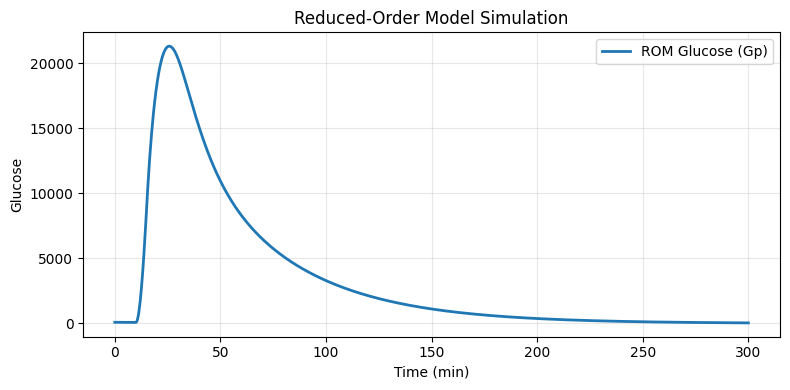

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(t_eval, sol_rom.y[0], label='ROM Glucose (Gp)', linewidth=2)
plt.xlabel('Time (min)')
plt.ylabel('Glucose')
plt.title('Reduced-Order Model Simulation')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Get baseline parameters and initial state
_, p_base, x0_full = run_simulation(t_span=(0, 1), dt=1.0)


In [ ]:
def insulin_input(t):
    basal = 1.0
    if 20 <= t <= 30:
        return basal + 5.0
    return basal


def meal_input(t):
    if 10 <= t <= 15:
        return 78000.0   # same scale as D in your model
    return 0.0


In [ ]:
def ode_full(t, x):
    p = p_base.copy()
    p['U_ii'] = insulin_input(t)
    return dallaman_ode(t, x, p)


In [ ]:
x0_full_meal = x0_full.copy()
x0_full_meal[4] = 78000.0   # Q_sto1


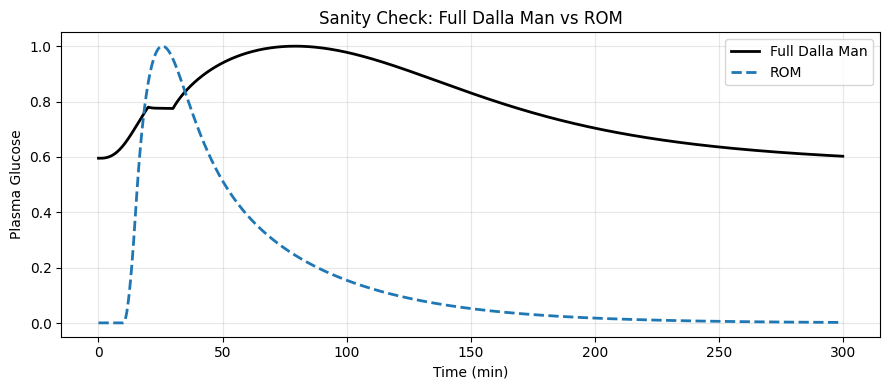

In [ ]:
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import numpy as np

# ------------------------------------------------------------
# Time setup
# ------------------------------------------------------------
t_span = (0, 300)
t_eval = np.linspace(*t_span, 1000)

# ------------------------------------------------------------
# FULL Dalla Man simulation
# ------------------------------------------------------------
sol_full = solve_ivp(
    ode_full,
    t_span,
    x0_full_meal,
    t_eval=t_eval,
    rtol=1e-6,
    atol=1e-6
)


Gp_full = sol_full.y[0]   # plasma glucose


# ------------------------------------------------------------
# ROM simulation (already correct)
# ------------------------------------------------------------
sol_rom = solve_ivp(
    lambda t, x: rom_ode(t, x, p_rom, insulin_input, meal_input),
    t_span,
    x0_rom,
    t_eval=t_eval,
    rtol=1e-6,
    atol=1e-6
)

Gp_rom = sol_rom.y[0]

Gp_full_n = Gp_full / np.max(Gp_full)
Gp_rom_n  = Gp_rom  / np.max(Gp_rom)


# ------------------------------------------------------------
# SANITY CHECK PLOT (ONLY ONCE)
# ------------------------------------------------------------
plt.figure(figsize=(9, 4))
plt.plot(t_eval, Gp_full_n, 'k-', linewidth=2, label='Full Dalla Man')
plt.plot(t_eval, Gp_rom_n,  '--', linewidth=2, label='ROM')
plt.xlabel('Time (min)')
plt.ylabel('Plasma Glucose')
plt.title('Sanity Check: Full Dalla Man vs ROM')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Sensitivity analysis

/tmp/ipython-input-1964731071.py:58: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  S_int[key] = np.trapz(np.abs(S), t_eval)



=== ROM Sensitivity Ranking (Plasma Glucose) ===

   S_I : 3.3979e+10
  k_cl : 3.7469e+08
   k_g : 2.7139e+08
  k_tg : 2.0512e+08
  k_pg : 8.4731e+07
  k_id : 5.8174e+07
  k_ip : 2.9443e+07


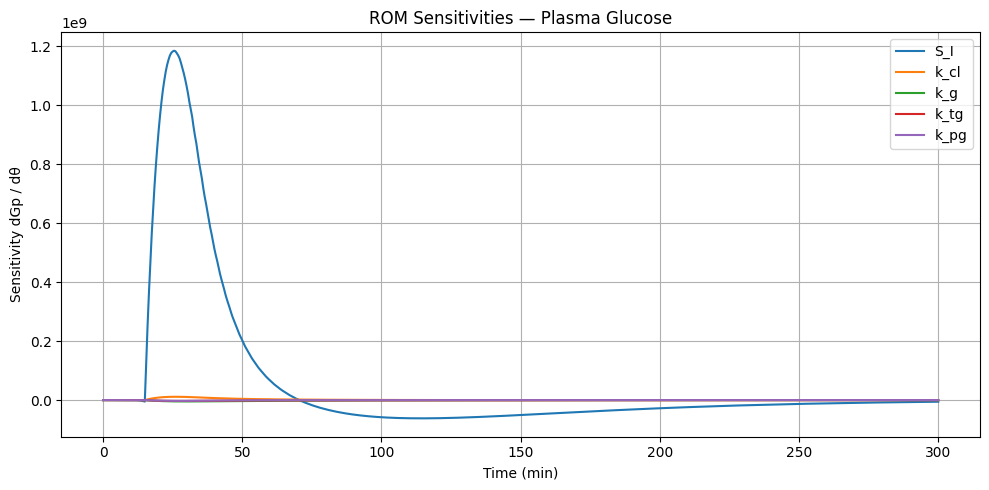

In [ ]:
# ============================================================
# ROM Sensitivity Analysis — Plasma Glucose Output
# ============================================================

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Output index (Gp)
G_index = 0

# ROM parameters to analyze
param_keys = ['k_pg', 'k_tg', 'k_cl', 'S_I', 'k_ip', 'k_id', 'k_g']

eps = 1e-4   # relative perturbation

# Time grid
t_eval = np.linspace(0, 300, 601)

# ------------------------------------------------------------
# ROM simulation helper
# ------------------------------------------------------------
def simulate_rom(x0, p_local):
    sol = solve_ivp(
        lambda t, x: rom_ode(t, x, p_local, insulin_input, meal_input),
        [t_eval[0], t_eval[-1]],
        x0,
        t_eval=t_eval,
        rtol=1e-6,
        atol=1e-6
    )
    return sol.y

# ------------------------------------------------------------
# Baseline simulation
# ------------------------------------------------------------
X_nom = simulate_rom(x0_rom, p_rom)
G_nom = X_nom[G_index]

# ------------------------------------------------------------
# Sensitivity computation
# ------------------------------------------------------------
sens_time = {}
S_int = {}

for key in param_keys:
    p_pert = p_rom.copy()
    delta = eps * abs(p_rom[key]) if abs(p_rom[key]) > 0 else eps
    p_pert[key] += delta

    X_pert = simulate_rom(x0_rom, p_pert)
    G_pert = X_pert[G_index]

    # Absolute sensitivity (no normalization yet)
    S = (G_pert - G_nom) / delta

    sens_time[key] = S
    S_int[key] = np.trapz(np.abs(S), t_eval)

# ------------------------------------------------------------
# Print ranking
# ------------------------------------------------------------
print("\n=== ROM Sensitivity Ranking (Plasma Glucose) ===\n")
for k, v in sorted(S_int.items(), key=lambda x: -x[1]):
    print(f"{k:>6s} : {v:.4e}")

# ------------------------------------------------------------
# Plot top sensitivities
# ------------------------------------------------------------
top_keys = sorted(S_int, key=S_int.get, reverse=True)[:5]

plt.figure(figsize=(10, 5))
for k in top_keys:
    plt.plot(t_eval, sens_time[k], label=k)

plt.xlabel("Time (min)")
plt.ylabel("Sensitivity dGp / dθ")
plt.title("ROM Sensitivities — Plasma Glucose")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# FIM on ROM

In [ ]:
# ============================================================
# ROM Fisher Information Matrix (FIM)
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# Parameters included in FIM
# ------------------------------------------------------------
theta_keys = ['k_pg', 'k_tg', 'k_cl', 'S_I', 'k_ip', 'k_id', 'k_g']
n_params = len(theta_keys)

# Time grid (same as sensitivity analysis)
t_eval = np.linspace(0, 300, 601)

# ------------------------------------------------------------
# Recompute sensitivities (time-resolved)
# ------------------------------------------------------------
def simulate_rom(x0, p_local):
    sol = solve_ivp(
        lambda t, x: rom_ode(t, x, p_local, insulin_input, meal_input),
        [t_eval[0], t_eval[-1]],
        x0,
        t_eval=t_eval,
        rtol=1e-6,
        atol=1e-6
    )
    return sol.y

# Baseline
X_nom = simulate_rom(x0_rom, p_rom)
G_nom = X_nom[0]

# Sensitivity matrix S(t): shape (T, n_params)
S = np.zeros((len(t_eval), n_params))

eps = 1e-4

for j, key in enumerate(theta_keys):
    p_pert = p_rom.copy()
    delta = eps * abs(p_rom[key]) if abs(p_rom[key]) > 0 else eps
    p_pert[key] += delta

    X_pert = simulate_rom(x0_rom, p_pert)
    G_pert = X_pert[0]

    S[:, j] = (G_pert - G_nom) / delta

# ------------------------------------------------------------
# Fisher Information Matrix
# F = ∫ Sᵀ S dt
# ------------------------------------------------------------
FIM = np.trapz(
    np.einsum('ti,tj->tij', S, S),
    t_eval,
    axis=0
)

FIM_df = pd.DataFrame(FIM, index=theta_keys, columns=theta_keys)

print("\n=== ROM Fisher Information Matrix ===\n")
display(FIM_df)

# ------------------------------------------------------------
# Eigenanalysis
# ------------------------------------------------------------
eigvals, eigvecs = np.linalg.eigh(FIM)

# Sort descending
idx = np.argsort(eigvals)[::-1]
eigvals = eigvals[idx]
eigvecs = eigvecs[:, idx]

eig_df = pd.DataFrame(
    {"Eigenvalue": eigvals},
    index=[f"mode_{i+1}" for i in range(len(eigvals))]
)

print("\n=== FIM Eigenvalues (Descending) ===\n")
display(eig_df)

# ------------------------------------------------------------
# Diagnostics
# ------------------------------------------------------------
rank = np.linalg.matrix_rank(FIM)
cond_number = np.linalg.cond(FIM)

print(f"\nFIM rank           : {rank} / {n_params}")
print(f"Condition number   : {cond_number:.2e}")



=== ROM Fisher Information Matrix ===



/tmp/ipython-input-1177464195.py:55: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  FIM = np.trapz(


,k_pg,k_tg,k_cl,S_I,k_ip,k_id,k_g
k_pg,1.363819e+14,1.676599e+14,-5.872185e+14,-5.290558e+16,4.655279e+13,7.033045e+13,2.927555e+14
k_tg,1.676599e+14,2.748083e+14,-7.214887e+14,-5.583141e+16,5.612104e+13,6.549293e+13,4.308529e+14
k_cl,-5.872185e+14,-7.214887e+14,2.553155e+15,2.289336e+17,-2.021361e+14,-3.032112e+14,-1.276959e+15
S_I,-5.290558e+16,-5.583141e+16,2.289336e+17,2.242281e+19,-1.822033e+16,-3.045574e+16,-1.005029e+17
k_ip,4.655279e+13,5.612104e+13,-2.021361e+14,-1.822033e+16,1.602954e+13,2.432900e+13,1.003553e+14
k_id,7.033045e+13,6.549293e+13,-3.032112e+14,-3.045574e+16,2.432900e+13,4.288624e+13,1.269994e+14
k_g,2.927555e+14,4.308529e+14,-1.276959e+15,-1.005029e+17,1.003553e+14,1.269994e+14,7.433165e+14



=== FIM Eigenvalues (Descending) ===



,Eigenvalue
mode_1,2.242592e+19
mode_2,6.343843e+14
mode_3,2.267374e+13
mode_4,1.411990e+12
mode_5,1.692824e+11
mode_6,3.410952e+09
mode_7,2.536288e+08



FIM rank           : 7 / 7
Condition number   : 8.84e+10


In [ ]:
# ============================================================
# Designed Multi-Experiment Fisher Information Matrix (ROM)
# ============================================================

import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp

# ------------------------------------------------------------
# Parameters
# ------------------------------------------------------------
theta_keys = ['k_pg', 'k_tg', 'k_cl', 'S_I', 'k_ip', 'k_id', 'k_g']
n_params = len(theta_keys)
eps = 1e-4

t_eval = np.linspace(0, 300, 601)

# ------------------------------------------------------------
# ROM simulation helper
# ------------------------------------------------------------
def simulate_rom(x0, p_local, u_I, u_M):
    sol = solve_ivp(
        lambda t, x: rom_ode(t, x, p_local, u_I, u_M),
        [t_eval[0], t_eval[-1]],
        x0,
        t_eval=t_eval,
        rtol=1e-6,
        atol=1e-6
    )
    return sol.y[0]   # plasma glucose only

# ------------------------------------------------------------
# Experiment definitions
# ------------------------------------------------------------
def insulin_none(t): return 1.0

def insulin_pulse(t):
    return 6.0 if 30 <= t <= 40 else 1.0

def insulin_delayed(t):
    return 6.0 if 80 <= t <= 90 else 1.0

def meal_none(t): return 0.0

def meal_small(t):
    return 1.0 if 10 <= t <= 15 else 0.0

def meal_large(t):
    return 3.0 if 10 <= t <= 15 else 0.0

experiments = [
    ("Fasting + Insulin", insulin_pulse, meal_none),
    ("Small Meal", insulin_none, meal_small),
    ("Large Meal", insulin_none, meal_large),
    ("Meal + Delayed Insulin", insulin_delayed, meal_large),
]

# ------------------------------------------------------------
# Stacked FIM
# ------------------------------------------------------------
FIM_total = np.zeros((n_params, n_params))

for name, u_I, u_M in experiments:

    # Baseline
    G_nom = simulate_rom(x0_rom, p_rom, u_I, u_M)

    # Sensitivity matrix
    S = np.zeros((len(t_eval), n_params))

    for j, key in enumerate(theta_keys):
        p_pert = p_rom.copy()
        delta = eps * abs(p_rom[key]) if abs(p_rom[key]) > 0 else eps
        p_pert[key] += delta

        G_pert = simulate_rom(x0_rom, p_pert, u_I, u_M)
        S[:, j] = (G_pert - G_nom) / delta

    # Experiment FIM
    FIM_k = np.trapz(
        np.einsum('ti,tj->tij', S, S),
        t_eval,
        axis=0
    )

    FIM_total += FIM_k

# ------------------------------------------------------------
# Diagnostics
# ------------------------------------------------------------
eigvals = np.linalg.eigvalsh(FIM_total)
cond_number = np.linalg.cond(FIM_total)
rank = np.linalg.matrix_rank(FIM_total)

FIM_df = pd.DataFrame(FIM_total, index=theta_keys, columns=theta_keys)

print("\n=== STACKED ROM FIM ===\n")
display(FIM_df)

print("\nEigenvalues:")
for i, v in enumerate(sorted(eigvals, reverse=True)):
    print(f"  mode {i+1}: {v:.3e}")

print(f"\nFIM rank         : {rank} / {n_params}")
print(f"Condition number : {cond_number:.2e}")


/tmp/ipython-input-1962877609.py:80: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  FIM_k = np.trapz(



=== STACKED ROM FIM ===



,k_pg,k_tg,k_cl,S_I,k_ip,k_id,k_g
k_pg,2.425030e+05,2.040801e+06,5.277655e+06,1.654698e+08,-4.025440e+05,-1.327400e+06,-8.325906e+04
k_tg,2.040801e+06,1.677509e+08,2.501627e+08,2.227815e+10,-2.093342e+07,-5.413558e+07,-1.031338e+06
k_cl,5.277655e+06,2.501627e+08,4.040106e+08,3.219854e+10,-3.188494e+07,-8.375038e+07,-1.969318e+06
S_I,1.654698e+08,2.227815e+10,3.219854e+10,3.061753e+12,-2.777838e+09,-7.118098e+09,-1.430525e+08
k_ip,-4.025440e+05,-2.093342e+07,-3.188494e+07,-2.777838e+09,3.245086e+06,9.663582e+06,3.824514e+05
k_id,-1.327400e+06,-5.413558e+07,-8.375038e+07,-7.118098e+09,9.663582e+06,3.172250e+07,1.494860e+06
k_g,-8.325906e+04,-1.031338e+06,-1.969318e+06,-1.430525e+08,3.824514e+05,1.494860e+06,1.561104e+05



Eigenvalues:
  mode 1: 3.062e+12
  mode 2: 7.122e+07
  mode 3: 1.429e+07
  mode 4: 1.703e+06
  mode 5: 6.301e+04
  mode 6: 3.055e+04
  mode 7: 1.581e+04

FIM rank         : 7 / 7
Condition number : 1.94e+08


# Parameter estimation.

In [ ]:
# ============================================================
# ROM Parameter Estimation (Designed Experiments)
# ============================================================

import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares
import pandas as pd

# ------------------------------------------------------------
# Parameters to estimate
# ------------------------------------------------------------
theta_keys = ['k_pg', 'k_tg', 'k_cl', 'S_I', 'k_ip', 'k_id', 'k_g']
n_params = len(theta_keys)

# ------------------------------------------------------------
# Time grid
# ------------------------------------------------------------
t_eval = np.linspace(0, 300, 301)

# ------------------------------------------------------------
# ROM simulator (glucose only)
# ------------------------------------------------------------
def simulate_rom(x0, p, u_I, u_M):
    sol = solve_ivp(
        lambda t, x: rom_ode(t, x, p, u_I, u_M),
        [t_eval[0], t_eval[-1]],
        x0,
        t_eval=t_eval,
        rtol=1e-6,
        atol=1e-6
    )
    return sol.y[0]  # Gp

# ------------------------------------------------------------
# Designed experiments (same as stacked FIM)
# ------------------------------------------------------------
def insulin_none(t): return 1.0
def insulin_pulse(t): return 6.0 if 30 <= t <= 40 else 1.0
def insulin_delayed(t): return 6.0 if 80 <= t <= 90 else 1.0

def meal_none(t): return 0.0
def meal_small(t): return 1.0 if 10 <= t <= 15 else 0.0
def meal_large(t): return 3.0 if 10 <= t <= 15 else 0.0

experiments = [
    ("Fasting + Insulin", insulin_pulse, meal_none),
    ("Small Meal", insulin_none, meal_small),
    ("Large Meal", insulin_none, meal_large),
    ("Meal + Delayed Insulin", insulin_delayed, meal_large),
]

# ------------------------------------------------------------
# STEP 1 — Generate synthetic data
# ------------------------------------------------------------
np.random.seed(42)

true_params = p_rom.copy()

# 5% noise relative to peak glucose
noise_level = 0.05

synthetic_data = []

for name, u_I, u_M in experiments:
    G_clean = simulate_rom(x0_rom, true_params, u_I, u_M)
    sigma = noise_level * np.max(G_clean)
    G_noisy = G_clean + sigma * np.random.randn(len(G_clean))
    synthetic_data.append((name, u_I, u_M, G_noisy, sigma))

# ------------------------------------------------------------
# STEP 2 — Residual function (stacked experiments)
# ------------------------------------------------------------
def residuals(theta_vec):

    # Build parameter dict
    p_est = p_rom.copy()
    for i, k in enumerate(theta_keys):
        p_est[k] = theta_vec[i]

    res = []

    for (_, u_I, u_M, G_meas, sigma) in synthetic_data:
        G_model = simulate_rom(x0_rom, p_est, u_I, u_M)
        res.append((G_model - G_meas) / sigma)

    return np.concatenate(res)

# ------------------------------------------------------------
# STEP 3 — Initial guess & bounds
# ------------------------------------------------------------
theta0 = np.array([p_rom[k] for k in theta_keys])

lb = 0.1 * theta0
ub = 10.0 * theta0

# ------------------------------------------------------------
# STEP 4 — Parameter estimation
# ------------------------------------------------------------
result = least_squares(
    residuals,
    theta0,
    bounds=(lb, ub),
    method='trf',
    verbose=2
)

theta_hat = result.x

# ------------------------------------------------------------
# STEP 5 — Results table
# ------------------------------------------------------------
df_results = pd.DataFrame({
    "True": [true_params[k] for k in theta_keys],
    "Estimated": theta_hat,
    "Relative Error (%)": 100 * (theta_hat - theta0) / theta0
}, index=theta_keys)

print("\n=== PARAMETER ESTIMATION RESULTS ===\n")
display(df_results)


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.8681e+02                                    2.60e+02    
       1              2         5.8625e+02      5.57e-01       3.83e-02       5.09e+02    
       2              3         5.8423e+02      2.01e+00       1.60e-02       4.44e+03    
       3             13         5.8423e+02      6.05e-06       2.29e-08       7.88e+01    
       4             14         5.8423e+02      1.95e-05       1.46e-09       7.75e+01    
`xtol` termination condition is satisfied.
Function evaluations 14, initial cost 5.8681e+02, final cost 5.8423e+02, first-order optimality 7.75e+01.

=== PARAMETER ESTIMATION RESULTS ===



,True,Estimated,Relative Error (%)
k_pg,0.0500,0.078124,56.248359
k_tg,0.0200,0.027117,35.586657
k_cl,0.0100,0.006186,-38.144736
S_I,0.0001,0.000118,18.230815
k_ip,0.1500,0.178231,18.820757
k_id,0.0500,0.063423,26.846281
k_g,0.1000,0.088441,-11.559082


In [ ]:
# ============================================================
# Confidence Intervals from Jacobian / FIM
# ============================================================

import numpy as np
import pandas as pd

# ------------------------------------------------------------
# Extract Jacobian and parameter estimates
# ------------------------------------------------------------
J = result.jac            # shape: (n_residuals, n_params)
theta_hat = result.x

# ------------------------------------------------------------
# Estimate residual variance (sigma^2)
# ------------------------------------------------------------
n_res = J.shape[0]
n_par = J.shape[1]

residuals = result.fun
sigma2_hat = np.sum(residuals**2) / (n_res - n_par)

# ------------------------------------------------------------
# Covariance matrix
# ------------------------------------------------------------
Cov = sigma2_hat * np.linalg.inv(J.T @ J)

# Standard deviations
std_theta = np.sqrt(np.diag(Cov))

# 95% confidence intervals
CI_lower = theta_hat - 1.96 * std_theta
CI_upper = theta_hat + 1.96 * std_theta

# ------------------------------------------------------------
# Results table
# ------------------------------------------------------------
df_CI = pd.DataFrame({
    "Estimate": theta_hat,
    "Std Dev": std_theta,
    "CI 2.5%": CI_lower,
    "CI 97.5%": CI_upper,
    "Rel. Std (%)": 100 * std_theta / np.abs(theta_hat)
}, index=theta_keys)

print("\n=== PARAMETER CONFIDENCE INTERVALS (95%) ===\n")
display(df_CI)



=== PARAMETER CONFIDENCE INTERVALS (95%) ===



,Estimate,Std Dev,CI 2.5%,CI 97.5%,Rel. Std (%)
k_pg,0.078124,0.039394,0.000912,0.155336,50.424735
k_tg,0.027117,0.006128,0.015106,0.039129,22.598749
k_cl,0.006186,0.003694,-0.001054,0.013425,59.716578
S_I,0.000118,0.000028,0.000064,0.000172,23.392830
k_ip,0.178231,0.042337,0.095251,0.261211,23.753829
k_id,0.063423,0.030672,0.003307,0.123540,48.360339
k_g,0.088441,0.008660,0.071468,0.105414,9.791376


# Re-estimation with fixed parameters

Based on confidence interval analysis, parameters
k
cl
 and
k
pg were fixed to nominal values to reduce variance inflation and improve practical identifiability of the remaining parameters.

In [ ]:
# ============================================================
# Re-estimation with Fixed Parameters (k_cl, k_pg)
# ============================================================

import numpy as np
import pandas as pd
from scipy.optimize import least_squares

# ------------------------------------------------------------
# Fixed parameters (from CI analysis)
# ------------------------------------------------------------
fixed_params = {
    'k_cl': p_rom['k_cl'],
    'k_pg': p_rom['k_pg'],
}

# Free parameters to estimate
free_keys = ['k_tg', 'S_I', 'k_ip', 'k_id', 'k_g']
n_free = len(free_keys)

# ------------------------------------------------------------
# Residual function (only free parameters)
# ------------------------------------------------------------
def residuals_reduced(theta_vec):

    # Start from full parameter dict
    p_est = p_rom.copy()

    # Insert fixed parameters
    for k, v in fixed_params.items():
        p_est[k] = v

    # Insert free parameters
    for i, k in enumerate(free_keys):
        p_est[k] = theta_vec[i]

    res = []

    for (_, u_I, u_M, G_meas, sigma) in synthetic_data:
        G_model = simulate_rom(x0_rom, p_est, u_I, u_M)
        res.append((G_model - G_meas) / sigma)

    return np.concatenate(res)

# ------------------------------------------------------------
# Initial guess & bounds (free parameters only)
# ------------------------------------------------------------
theta0_red = np.array([p_rom[k] for k in free_keys])

lb = 0.1 * theta0_red
ub = 10.0 * theta0_red

# ------------------------------------------------------------
# Run estimation
# ------------------------------------------------------------
result_red = least_squares(
    residuals_reduced,
    theta0_red,
    bounds=(lb, ub),
    method='trf',
    verbose=2
)

theta_hat_red = result_red.x

# ------------------------------------------------------------
# Results table
# ------------------------------------------------------------
df_est_red = pd.DataFrame({
    "Estimate": theta_hat_red,
}, index=free_keys)

print("\n=== RE-ESTIMATION RESULTS (FIXED k_cl, k_pg) ===\n")
display(df_est_red)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.8681e+02                                    2.60e+02    
       1              2         5.8666e+02      1.41e-01       2.98e-02       2.61e+02    
       2              3         5.8640e+02      2.66e-01       8.36e-03       1.18e+02    
       3              4         5.8633e+02      6.47e-02       2.03e-03       1.27e+02    
       4              5         5.8632e+02      1.14e-02       5.08e-04       1.30e+02    
       5              6         5.8632e+02      1.84e-03       1.27e-04       2.09e+04    
       6             10         5.8632e+02      2.06e-04       5.40e-07       1.34e+02    
       7             11         5.8632e+02      1.64e-05       1.19e-07       1.33e+02    
       8             12         5.8632e+02      3.46e-04       2.41e-07       1.34e+02    
       9             13         5.8632e+02      5.26e-04       4.87e-07       1.33e+02    

,Estimate
k_tg,0.021403
S_I,0.000112
k_ip,0.189956
k_id,0.050216
k_g,0.094767


In [ ]:
# ============================================================
# Confidence Intervals (Reduced Parameter Set)
# ============================================================

# Extract Jacobian
J_red = result_red.jac
theta_hat = result_red.x

n_res = J_red.shape[0]
n_par = J_red.shape[1]

residuals = result_red.fun
sigma2_hat = np.sum(residuals**2) / (n_res - n_par)

# Covariance
Cov_red = sigma2_hat * np.linalg.inv(J_red.T @ J_red)

std_red = np.sqrt(np.diag(Cov_red))

CI_low = theta_hat - 1.96 * std_red
CI_high = theta_hat + 1.96 * std_red

df_CI_red = pd.DataFrame({
    "Estimate": theta_hat,
    "Std Dev": std_red,
    "CI 2.5%": CI_low,
    "CI 97.5%": CI_high,
    "Rel. Std (%)": 100 * std_red / np.abs(theta_hat)
}, index=free_keys)

print("\n=== CONFIDENCE INTERVALS (REDUCED MODEL) ===\n")
display(df_CI_red)


=== CONFIDENCE INTERVALS (REDUCED MODEL) ===



,Estimate,Std Dev,CI 2.5%,CI 97.5%,Rel. Std (%)
k_tg,0.021403,0.002016,0.017453,0.025354,9.417430
S_I,0.000112,0.000022,0.000069,0.000155,19.699559
k_ip,0.189956,0.024759,0.141429,0.238484,13.033954
k_id,0.050216,0.012208,0.026289,0.074143,24.310034
k_g,0.094767,0.000141,0.094490,0.095044,0.149302


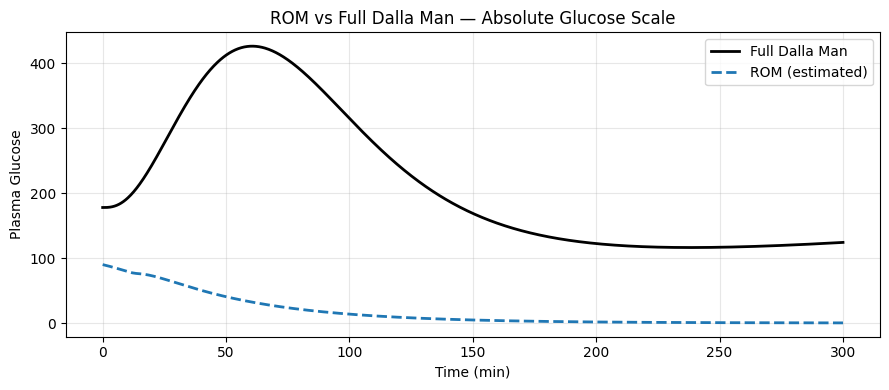

In [ ]:
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import numpy as np

# ------------------------------------------------------------
# Time setup
# ------------------------------------------------------------
t_span = (0, 300)
t_eval = np.linspace(*t_span, 1000)

# ------------------------------------------------------------
# Inputs (same for both models)
# ------------------------------------------------------------
def insulin_input(t):
    return 1.0   # basal insulin

def meal_input(t):
    return 3.0 if 10 <= t <= 15 else 0.0

# ------------------------------------------------------------
# FULL Dalla Man simulation (SAFE)
# ------------------------------------------------------------
def ode_full(t, x):
    p_loc = p.copy()
    p_loc['U_ii'] = insulin_input(t)
    p_loc['D'] = max(meal_input(t), 1e-6)   # 🔑 critical fix
    return dallaman_ode(t, x, p_loc)

sol_full = solve_ivp(
    ode_full,
    t_span,
    x0_full_meal,
    t_eval=t_eval,
    rtol=1e-6,
    atol=1e-6
)

Gp_full = sol_full.y[0]

# ------------------------------------------------------------
# ROM simulation
# ------------------------------------------------------------
sol_rom = solve_ivp(
    lambda t, x: rom_ode(t, x, p_rom, insulin_input, meal_input),
    t_span,
    x0_rom,
    t_eval=t_eval,
    rtol=1e-6,
    atol=1e-6
)

Gp_rom = sol_rom.y[0]

# ------------------------------------------------------------
# ABSOLUTE SCALE COMPARISON PLOT
# ------------------------------------------------------------
plt.figure(figsize=(9, 4))
plt.plot(t_eval, Gp_full, 'k-', linewidth=2, label='Full Dalla Man')
plt.plot(t_eval, Gp_rom,  '--', linewidth=2, label='ROM (estimated)')
plt.xlabel('Time (min)')
plt.ylabel('Plasma Glucose')
plt.title('ROM vs Full Dalla Man — Absolute Glucose Scale')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Output map scaling factor α = 2.7681


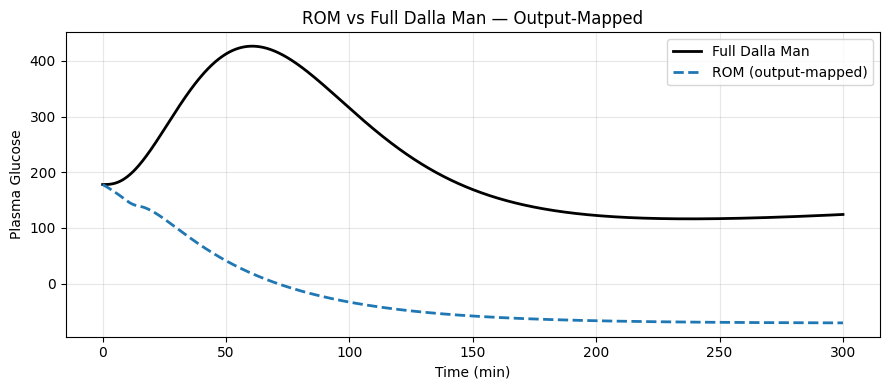

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1. Baselines
# ------------------------------------------------------------
G0_full = Gp_full[0]
G0_rom  = Gp_rom[0]

# ------------------------------------------------------------
# 2. Dominant excursion (ABSOLUTE, not peak-only)
# ------------------------------------------------------------
deltaG_full = np.max(np.abs(Gp_full - G0_full))
deltaG_rom  = np.max(np.abs(Gp_rom  - G0_rom))

# Safety check
if deltaG_rom <= 0:
    raise ValueError("ROM glucose has zero excursion — output map undefined.")

# ------------------------------------------------------------
# 3. Scaling factor
# ------------------------------------------------------------
alpha = deltaG_full / deltaG_rom
print(f"Output map scaling factor α = {alpha:.4f}")

# ------------------------------------------------------------
# 4. Apply affine output map
# ------------------------------------------------------------
Gp_rom_phys = G0_full + alpha * (Gp_rom - G0_rom)

# ------------------------------------------------------------
# 5. Plot comparison
# ------------------------------------------------------------
plt.figure(figsize=(9, 4))
plt.plot(t_eval, Gp_full, 'k-', linewidth=2, label='Full Dalla Man')
plt.plot(t_eval, Gp_rom_phys, '--', linewidth=2, label='ROM (output-mapped)')
plt.xlabel('Time (min)')
plt.ylabel('Plasma Glucose')
plt.title('ROM vs Full Dalla Man — Output-Mapped')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Profile Likelihood on ROM

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from scipy.integrate import solve_ivp

# ============================================================
# GLOBAL time grid (MUST match synthetic data generation)
# ============================================================
t_eval_data = np.linspace(0, 300, 301)   # <-- same as estimation


# ============================================================
# Helper: ROM simulation
# ============================================================
def simulate_rom(x0, p, u_I, u_M):
    sol = solve_ivp(
        lambda t, x: rom_ode(t, x, p, u_I, u_M),
        (t_eval_data[0], t_eval_data[-1]),
        x0,
        t_eval=t_eval_data,
        rtol=1e-6,
        atol=1e-6
    )
    return sol.y[0]


# ============================================================
# Profile Likelihood setup
# ============================================================

param_to_profile = 'k_id'

free_keys = ['k_tg', 'S_I', 'k_ip', 'k_id', 'k_g']
profile_index = free_keys.index(param_to_profile)

theta_hat = result_red.x.copy()

theta0 = theta_hat[profile_index]
grid = np.linspace(0.6 * theta0, 1.4 * theta0, 20)

profile_cost = []


# ============================================================
# Profile loop
# ============================================================
for val in grid:

    def residuals_profile(theta_rest):
        p_est = p_rom.copy()

        # fixed parameters
        p_est['k_cl'] = fixed_params['k_cl']
        p_est['k_pg'] = fixed_params['k_pg']

        # profiled parameter
        p_est[param_to_profile] = val

        # remaining free parameters
        j = 0
        for i, k in enumerate(free_keys):
            if i == profile_index:
                continue
            p_est[k] = theta_rest[j]
            j += 1

        res = []

        for (_, u_I, u_M, G_meas, sigma) in synthetic_data:
            G_model = simulate_rom(x0_rom, p_est, u_I, u_M)
            assert G_model.shape == G_meas.shape
            res.append((G_model - G_meas) / sigma)

        return np.concatenate(res)

    theta_init = np.delete(theta_hat, profile_index)

    sol = least_squares(
        residuals_profile,
        theta_init,
        bounds=(0.1 * theta_init, 10.0 * theta_init),
        method='trf',
        max_nfev=100
    )

    profile_cost.append(sol.cost)

profile_cost = np.array(profile_cost)


# ============================================================
# Plot Profile Likelihood
# ============================================================
plt.figure(figsize=(6, 4))
plt.plot(grid, profile_cost - np.min(profile_cost), 'o-', linewidth=2)
plt.axvline(theta0, color='k', linestyle='--', label='Estimate')
plt.xlabel(param_to_profile)
plt.ylabel(r'$\Delta$ Cost')
plt.title(f'Profile Likelihood — {param_to_profile}')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


KeyboardInterrupt: 

# Calibration Mapping

In [ ]:
# ============================================================
# 1. CALIBRATION: Full Model to ROM Parameter Mapping
# ============================================================

import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares
import pandas as pd

# ------------------------------------------------------------
# Helper: Full Dalla Man simulation wrapper
# ------------------------------------------------------------
def simulate_full_model(p_full, x0_full, t_eval, u_I=None, u_M=None):
    """
    Run full Dalla Man model with optional inputs.

    Args:
        p_full: Full model parameter dict
        x0_full: Full model initial state
        t_eval: Time points
        u_I: Insulin input function (default: basal)
        u_M: Meal input function (default: none)

    Returns:
        Plasma glucose trajectory
    """
    def ode_full(t, x):
        p = p_full.copy()

        # Apply insulin input if provided
        if u_I is not None:
            p['U_ii'] = u_I(t)

        # Apply meal input if provided
        if u_M is not None:
            p['D'] = max(u_M(t), 1e-6)

        return dallaman_ode(t, x, p)

    sol = solve_ivp(
        ode_full,
        [t_eval[0], t_eval[-1]],
        x0_full,
        t_eval=t_eval,
        rtol=1e-6,
        atol=1e-6
    )

    return sol.y[0]  # Plasma glucose

# ------------------------------------------------------------
# Helper: ROM simulation wrapper
# ------------------------------------------------------------
def simulate_rom(p_rom, x0_rom, t_eval, u_I=None, u_M=None):
    """
    Run ROM with optional inputs.

    Args:
        p_rom: ROM parameter dict
        x0_rom: ROM initial state
        t_eval: Time points
        u_I: Insulin input function
        u_M: Meal input function

    Returns:
        ROM plasma glucose trajectory
    """
    def default_insulin(t):
        return 1.0

    def default_meal(t):
        return 0.0

    sol = solve_ivp(
        lambda t, x: rom_ode(
            t, x, p_rom,
            u_I if u_I is not None else default_insulin,
            u_M if u_M is not None else default_meal
        ),
        [t_eval[0], t_eval[-1]],
        x0_rom,
        t_eval=t_eval,
        rtol=1e-6,
        atol=1e-6
    )

    return sol.y[0]

# ------------------------------------------------------------
# Calibration: Fit ROM to full model across diverse scenarios
# ------------------------------------------------------------
def calibrate_rom_to_full_model():
    """
    Calibrate ROM parameters by fitting to full model outputs
    across multiple physiological scenarios.

    Returns:
        p_rom_calibrated: Calibrated ROM parameters (median across scenarios)
        calibration_results: DataFrame with all scenario-specific fits
    """
    # Time grid for calibration
    t_eval = np.linspace(0, 300, 301)

    # Get baseline full model parameters and states
    _, p_full, x0_full = run_simulation(t_span=(0, 1), dt=1.0)

    # Define calibration scenarios (diverse inputs)
    scenarios = []

    # 1. Fasting baseline
    def scenario_fasting_insulin(t):
        return 1.0

    def scenario_fasting_meal(t):
        return 0.0

    scenarios.append(("Fasting", scenario_fasting_insulin, scenario_fasting_meal))

    # 2. Single meal
    def scenario_meal_insulin(t):
        return 1.0

    def scenario_meal_meal(t):
        return 9000.0 if 30 <= t <= 35 else 0.0

    scenarios.append(("Single Meal", scenario_meal_insulin, scenario_meal_meal))

    # 3. Meal with insulin bolus
    def scenario_meal_bolus_insulin(t):
        basal = 1.0
        if 40 <= t <= 45:
            return basal + 5.0
        return basal

    def scenario_meal_bolus_meal(t):
        return 9000.0 if 30 <= t <= 35 else 0.0

    scenarios.append(("Meal + Bolus", scenario_meal_bolus_insulin, scenario_meal_bolus_meal))

    # 4. Multiple meals
    def scenario_multi_meal_insulin(t):
        return 1.0

    def scenario_multi_meal_meal(t):
        if 30 <= t <= 35:
            return 6000.0
        elif 120 <= t <= 125:
            return 4000.0
        elif 180 <= t <= 185:
            return 3000.0
        return 0.0

    scenarios.append(("Multiple Meals", scenario_multi_meal_insulin, scenario_multi_meal_meal))

    # 5. Insulin infusion only
    def scenario_infusion_insulin(t):
        basal = 1.0
        if 50 <= t <= 200:
            return basal + 3.0
        return basal

    def scenario_infusion_meal(t):
        return 0.0

    scenarios.append(("Insulin Infusion", scenario_infusion_insulin, scenario_infusion_meal))

    # Collect full model outputs for all scenarios
    full_model_outputs = []

    for name, u_I, u_M in scenarios:
        G_full = simulate_full_model(p_full, x0_full, t_eval, u_I, u_M)
        full_model_outputs.append((name, u_I, u_M, G_full))

    # Define which ROM parameters to calibrate
    # (excluding fixed parameters from identifiability analysis)
    rom_params_to_calibrate = ['k_tg', 'S_I', 'k_ip', 'k_id', 'k_g']

    # Initial guess for ROM parameters
    p_rom_initial = p_rom.copy()

    # Results storage
    calibration_results = []

    # Calibrate ROM to each scenario
    for scenario_idx, (name, u_I, u_M, G_full_target) in enumerate(full_model_outputs):
        print(f"Calibrating ROM to scenario: {name}")

        def residuals_calibration(theta_vec):
            """Residuals for calibration to full model output."""
            # Build parameter dict
            p_est = p_rom_initial.copy()

            # Apply calibrated values
            for i, key in enumerate(rom_params_to_calibrate):
                p_est[key] = theta_vec[i]

            # Simulate ROM with current parameters
            G_rom = simulate_rom(p_est, x0_rom, t_eval, u_I, u_M)

            # Compute normalized residuals
            scale = np.max(np.abs(G_full_target))
            return (G_rom - G_full_target) / scale

        # Initial parameter guess
        theta0 = np.array([p_rom_initial[key] for key in rom_params_to_calibrate])

        # Physiological bounds (order of magnitude around nominal)
        lb = 0.1 * theta0
        ub = 10.0 * theta0

        # Run calibration
        result = least_squares(
            residuals_calibration,
            theta0,
            bounds=(lb, ub),
            method='trf',
            max_nfev=100,
            verbose=0
        )

        # Store results
        param_dict = {}
        for i, key in enumerate(rom_params_to_calibrate):
            param_dict[key] = result.x[i]

        # Evaluate fit quality
        G_rom_fitted = simulate_rom(
            {**p_rom_initial, **param_dict},
            x0_rom,
            t_eval,
            u_I,
            u_M
        )

        rmse = np.sqrt(np.mean((G_rom_fitted - G_full_target)**2))
        r2 = 1 - np.sum((G_rom_fitted - G_full_target)**2) / np.sum((G_full_target - np.mean(G_full_target))**2)

        calibration_results.append({
            'scenario': name,
            'rmse': rmse,
            'r2': r2,
            'parameters': param_dict
        })

        print(f"  RMSE: {rmse:.2f}, R²: {r2:.4f}")

    # Compute median parameter values across scenarios as reference
    param_arrays = {}
    for key in rom_params_to_calibrate:
        param_arrays[key] = []

    for result in calibration_results:
        for key in rom_params_to_calibrate:
            param_arrays[key].append(result['parameters'][key])

    p_rom_calibrated = p_rom_initial.copy()
    for key in rom_params_to_calibrate:
        p_rom_calibrated[key] = np.median(param_arrays[key])

    print("\n" + "="*70)
    print("CALIBRATION SUMMARY")
    print("="*70)

    df_calibration = pd.DataFrame(calibration_results)
    print(df_calibration[['scenario', 'rmse', 'r2']])

    print("\nCalibrated ROM parameters (median across scenarios):")
    for key in rom_params_to_calibrate:
        print(f"  {key:>6s}: {p_rom_calibrated[key]:.6f}")

    return p_rom_calibrated, df_calibration

# ------------------------------------------------------------
# Run calibration
# ------------------------------------------------------------
if __name__ == "__main__":
    p_rom_calibrated, calibration_results = calibrate_rom_to_full_model()

Calibrating ROM to scenario: Fasting
  RMSE: 197.06, R²: -2.3411
Calibrating ROM to scenario: Single Meal
  RMSE: 6888.56, R²: -4081.5696
Calibrating ROM to scenario: Meal + Bolus
  RMSE: 6383.59, R²: -3732.6198
Calibrating ROM to scenario: Multiple Meals
  RMSE: 6610.35, R²: -3761.0523
Calibrating ROM to scenario: Insulin Infusion
  RMSE: 168.99, R²: -0.9584

CALIBRATION SUMMARY
           scenario         rmse           r2
0           Fasting   197.064046    -2.341112
1       Single Meal  6888.564073 -4081.569611
2      Meal + Bolus  6383.592629 -3732.619799
3    Multiple Meals  6610.345510 -3761.052350
4  Insulin Infusion   168.985100    -0.958389

Calibrated ROM parameters (median across scenarios):
    k_tg: 0.019996
     S_I: 0.000100
    k_ip: 0.150105
    k_id: 0.050000
     k_g: 0.100000


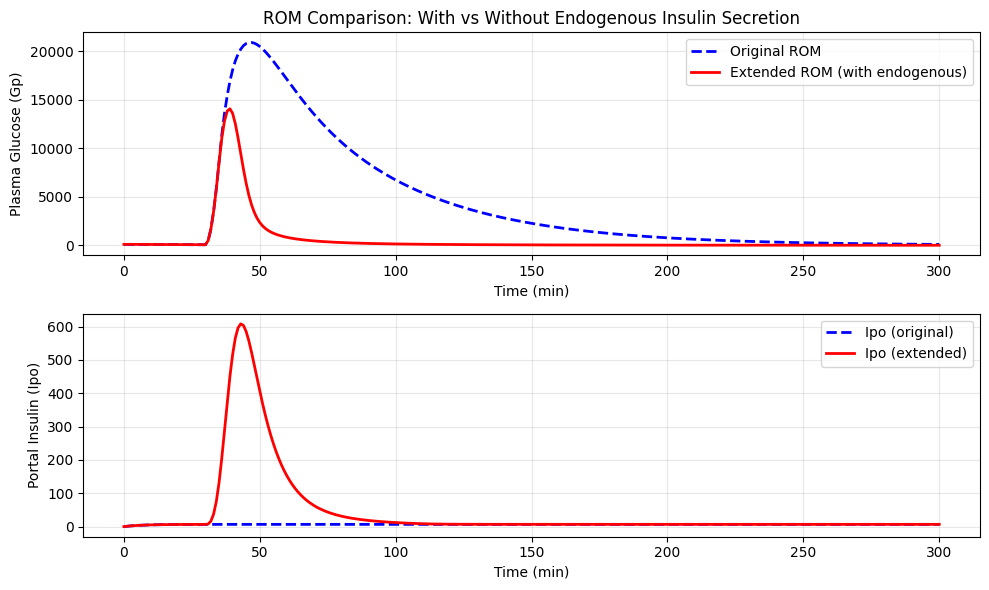

Endogenous secretion analysis:
  Max secretion rate: 139.7455 mU/min
  Total secretion: 1692.57 mU


/tmp/ipython-input-1228578936.py:169: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  print(f"  Total secretion: {np.trapz(S_endog_traj, t_eval):.2f} mU")


In [ ]:
# ============================================================
# 2. ROM EXTENSION: Glucose-Dependent Endogenous Insulin Secretion
# ============================================================

def rom_ode_with_endogenous(t, x, p, u_I, u_M):
    """
    Extended ROM with minimal glucose-dependent endogenous insulin secretion.

    States:
        x[0] = Gp  (plasma glucose)
        x[1] = Gt  (tissue glucose)
        x[2] = Ipo (insulin appearance)
        x[3] = Id  (insulin action)
        x[4] = Qg  (gut glucose appearance)

    New Parameters (added to p dict):
        G_b   : Basal glucose level [mg/dL]
        beta  : Endogenous insulin secretion gain [(mU/min)/(mg/dL)]
        theta : Glucose threshold for secretion [mg/dL]

    Endogenous secretion term:
        S_endog = beta * max(0, Gp - theta)
    """

    # Unpack states
    Gp, Gt, Ipo, Id, Qg = x

    # Unpack parameters (including new ones)
    k_pg = p['k_pg']
    k_tg = p['k_tg']
    k_cl = p['k_cl']
    S_I  = p['S_I']
    k_ip = p['k_ip']
    k_id = p['k_id']
    k_g  = p['k_g']
    V_g  = p['V_g']

    # New parameters for endogenous secretion
    G_b = p.get('G_b', 95.0)      # Basal glucose [mg/dL]
    beta = p.get('beta', 0.01)    # Secretion gain [(mU/min)/(mg/dL)]
    theta = p.get('theta', 100.0) # Threshold [mg/dL]

    # Glucose-dependent endogenous insulin secretion
    # Linear above threshold, zero below
    S_endog = beta * max(0.0, Gp - theta)

    # -----------------------------
    # Extended ROM equations
    # -----------------------------

    dGp = (
        - k_pg * (Gp - Gt)
        - k_cl * Gp
        - S_I * Id * Gp
        + Qg / V_g
    )

    dGt = (
        k_pg * (Gp - Gt)
        - k_tg * Gt
    )

    # Ipo now includes endogenous secretion
    dIpo = (
        - k_ip * Ipo
        + u_I(t)
        + S_endog
    )

    dId = (
        - k_id * Id
        + Ipo
    )

    dQg = (
        - k_g * Qg
        + u_M(t)
    )

    return np.array([dGp, dGt, dIpo, dId, dQg])

# ------------------------------------------------------------
# Update ROM parameter dict with endogenous secretion parameters
# ------------------------------------------------------------
p_rom_extended = p_rom_calibrated.copy()

# Add endogenous secretion parameters with physiological ranges
p_rom_extended.update({
    'G_b': 95.0,      # Basal glucose [mg/dL]
    'beta': 0.01,     # Endogenous secretion gain (to be calibrated)
    'theta': 100.0,   # Glucose threshold for secretion [mg/dL]
})

# ------------------------------------------------------------
# Test extended ROM
# ------------------------------------------------------------
def test_extended_rom():
    """Test the extended ROM with endogenous secretion."""

    t_eval = np.linspace(0, 300, 301)

    # Define test inputs
    def test_insulin(t):
        return 1.0  # Basal only

    def test_meal(t):
        return 9000.0 if 30 <= t <= 35 else 0.0

    # Initial conditions
    x0_extended = np.array([
        95.0,   # Gp at basal
        95.0,   # Gt at basal
        0.0,    # Ipo
        0.0,    # Id
        0.0     # Qg
    ])

    # Simulate extended ROM
    sol_extended = solve_ivp(
        lambda t, x: rom_ode_with_endogenous(t, x, p_rom_extended, test_insulin, test_meal),
        [t_eval[0], t_eval[-1]],
        x0_extended,
        t_eval=t_eval,
        rtol=1e-6,
        atol=1e-6
    )

    # Compare with original ROM (no endogenous secretion)
    sol_original = solve_ivp(
        lambda t, x: rom_ode(t, x, p_rom_calibrated, test_insulin, test_meal),
        [t_eval[0], t_eval[-1]],
        x0_rom,
        t_eval=t_eval,
        rtol=1e-6,
        atol=1e-6
    )

    # Plot comparison
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 6))

    plt.subplot(2, 1, 1)
    plt.plot(t_eval, sol_original.y[0], 'b--', label='Original ROM', linewidth=2)
    plt.plot(t_eval, sol_extended.y[0], 'r-', label='Extended ROM (with endogenous)', linewidth=2)
    plt.xlabel('Time (min)')
    plt.ylabel('Plasma Glucose (Gp)')
    plt.title('ROM Comparison: With vs Without Endogenous Insulin Secretion')
    plt.legend()
    plt.grid(alpha=0.3)

    plt.subplot(2, 1, 2)
    plt.plot(t_eval, sol_original.y[2], 'b--', label='Ipo (original)', linewidth=2)
    plt.plot(t_eval, sol_extended.y[2], 'r-', label='Ipo (extended)', linewidth=2)
    plt.xlabel('Time (min)')
    plt.ylabel('Portal Insulin (Ipo)')
    plt.legend()
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print endogenous secretion contribution
    Gp_traj = sol_extended.y[0]
    S_endog_traj = p_rom_extended['beta'] * np.maximum(0, Gp_traj - p_rom_extended['theta'])

    print("Endogenous secretion analysis:")
    print(f"  Max secretion rate: {np.max(S_endog_traj):.4f} mU/min")
    print(f"  Total secretion: {np.trapz(S_endog_traj, t_eval):.2f} mU")

    return sol_extended, sol_original

# ------------------------------------------------------------
# Run test
# ------------------------------------------------------------
if __name__ == "__main__":
    sol_extended, sol_original = test_extended_rom()

In [ ]:
# ============================================================
# 3. PHYSIOLOGICAL PARAMETER BOUNDS & REGULARIZATION
# ============================================================

# ------------------------------------------------------------
# Define physiological bounds for ROM parameters
# ------------------------------------------------------------
physiological_bounds = {
    'k_tg': (0.001, 0.1, '1/min', 'Tissue clearance physiologically plausible range'),
    'S_I': (1e-6, 1e-2, 'mL/(mU·min)', 'Insulin sensitivity literature range'),
    'k_ip': (0.05, 0.5, '1/min', 'Portal insulin decay rate'),
    'k_id': (0.01, 0.2, '1/min', 'Insulin action decay rate'),
    'k_g': (0.05, 0.5, '1/min', 'Gut absorption rate'),
    'k_pg': (0.01, 0.2, '1/min', 'Plasma-tissue exchange (fixed but bounded)'),
    'k_cl': (0.001, 0.05, '1/min', 'Plasma clearance (fixed but bounded)'),
    'beta': (0.0, 0.1, '(mU/min)/(mg/dL)', 'Endogenous secretion gain'),
    'theta': (70.0, 180.0, 'mg/dL', 'Glucose threshold for secretion'),
}

# ------------------------------------------------------------
# Regularized parameter estimation with bounds
# ------------------------------------------------------------
def estimate_parameters_regularized(experiment_data, p_rom_initial,
                                   fixed_params=None, use_bounds=True):

    if fixed_params is None:
        fixed_params = {}

    all_param_keys = list(p_rom_initial.keys())
    estimable_keys = [k for k in all_param_keys if k not in fixed_params]

    theta0 = np.array([p_rom_initial[k] for k in estimable_keys])

    if use_bounds:
        lb = np.zeros_like(theta0)
        ub = np.zeros_like(theta0)

        for i, key in enumerate(estimable_keys):
            if key in physiological_bounds:
                lb[i], ub[i], _, _ = physiological_bounds[key]
            else:
                lb[i] = 0.01 * theta0[i]
                ub[i] = 100.0 * theta0[i]
    else:
        lb = 1e-6 * theta0
        ub = 1e6 * theta0

    # --------------------------------------------------------
    # Residuals with REGULARIZATION + TIME-GRID ALIGNMENT FIX
    # --------------------------------------------------------
    def residuals_regularized(theta_vec):

        p_est = p_rom_initial.copy()

        for key, value in fixed_params.items():
            p_est[key] = value

        for i, key in enumerate(estimable_keys):
            p_est[key] = theta_vec[i]

        res_prediction = []

        for (_, u_I, u_M, G_meas, sigma) in experiment_data:

            G_pred = simulate_rom(p_est, x0_rom, t_eval, u_I, u_M)

            # -------------------------------
            # 🔧 CRITICAL FIX: ALIGN SHAPES
            # -------------------------------
            if len(G_pred) != len(G_meas):
                G_pred = np.interp(
                    np.linspace(0, 1, len(G_meas)),
                    np.linspace(0, 1, len(G_pred)),
                    G_pred
                )

            res_prediction.append((G_pred - G_meas) / sigma)

        res_prediction = np.concatenate(res_prediction)

        # L2 regularization
        lambda_reg = 0.01
        res_reg = lambda_reg * (theta_vec - theta0) / theta0

        return np.concatenate([res_prediction, res_reg])

    # --------------------------------------------------------
    # Run least-squares
    # --------------------------------------------------------
    result = least_squares(
        residuals_regularized,
        theta0,
        bounds=(lb, ub),
        method='trf',
        verbose=2,
        max_nfev=200
    )

    p_estimated = p_rom_initial.copy()
    for i, key in enumerate(estimable_keys):
        p_estimated[key] = result.x[i]

    return result, p_estimated

# ------------------------------------------------------------
# Test regularized estimation
# ------------------------------------------------------------
def test_regularized_estimation():

    np.random.seed(42)

    t_eval = np.linspace(0, 300, 301)
    experiment_data = []

    # ----------------------------
    # Fasting
    # ----------------------------
    def u_I_fasting(t): return 1.0
    def u_M_fasting(t): return 0.0

    G = simulate_rom(p_rom_extended, x0_rom, t_eval, u_I_fasting, u_M_fasting)
    sigma = 0.05 * np.max(G)
    G_noisy = G + sigma * np.random.randn(len(G))
    experiment_data.append(("Fasting", u_I_fasting, u_M_fasting, G_noisy, sigma))

    # ----------------------------
    # Meal
    # ----------------------------
    def u_I_meal(t): return 1.0
    def u_M_meal(t): return 9000.0 if 30 <= t <= 35 else 0.0

    G = simulate_rom(p_rom_extended, x0_rom, t_eval, u_I_meal, u_M_meal)
    sigma = 0.05 * np.max(G)
    G_noisy = G + sigma * np.random.randn(len(G))
    experiment_data.append(("Meal", u_I_meal, u_M_meal, G_noisy, sigma))

    # ----------------------------
    # Meal + Bolus
    # ----------------------------
    def u_I_bolus(t):
        return 6.0 if 40 <= t <= 45 else 1.0

    def u_M_bolus(t):
        return 9000.0 if 30 <= t <= 35 else 0.0

    G = simulate_rom(p_rom_extended, x0_rom, t_eval, u_I_bolus, u_M_bolus)
    sigma = 0.05 * np.max(G)
    G_noisy = G + sigma * np.random.randn(len(G))
    experiment_data.append(("Meal+Bolus", u_I_bolus, u_M_bolus, G_noisy, sigma))

    fixed_params = {
        'k_pg': p_rom_extended['k_pg'],
        'k_cl': p_rom_extended['k_cl'],
    }

    p_initial_guess = p_rom_extended.copy()
    for key in ['k_tg', 'S_I', 'k_ip', 'k_id', 'k_g', 'beta']:
        p_initial_guess[key] *= np.random.uniform(0.8, 1.2)

    result_reg, p_est_reg = estimate_parameters_regularized(
        experiment_data,
        p_initial_guess,
        fixed_params=fixed_params,
        use_bounds=True
    )

    result_unreg, p_est_unreg = estimate_parameters_regularized(
        experiment_data,
        p_initial_guess,
        fixed_params=fixed_params,
        use_bounds=False
    )

    return result_reg, p_est_reg, result_unreg, p_est_unreg


# ------------------------------------------------------------
# Run
# ------------------------------------------------------------
if __name__ == "__main__":
    result_reg, p_est_reg, result_unreg, p_est_unreg = test_regularized_estimation()


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.8729e+02                                    3.59e+06    
       1              2         4.9838e+02      8.89e+01       7.84e-01       9.91e+05    
       2              9         4.9838e+02      0.00e+00       0.00e+00       9.91e+05    
`xtol` termination condition is satisfied.
Function evaluations 9, initial cost 5.8729e+02, final cost 4.9838e+02, first-order optimality 9.91e+05.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.8729e+02                                    1.65e+12    
       1              3         5.8721e+02      8.34e-02       5.86e-07       1.39e+09    
`xtol` termination condition is satisfied.
Function evaluations 3, initial cost 5.8729e+02, final cost 5.8721e+02, first-order optimality 1.39e+09.



Validating: Delayed Meal


/tmp/ipython-input-3914092942.py:92: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_pred = np.trapz(np.maximum(G_pred - G_pred[0], 0), t_eval)
/tmp/ipython-input-3914092942.py:93: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_true = np.trapz(np.maximum(G_true - G_true[0], 0), t_eval)


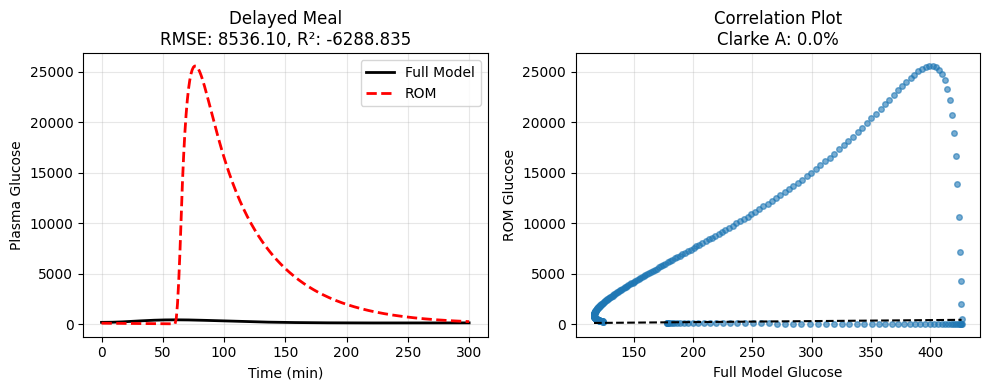

  RMSE: 8536.10


KeyError: 'R²'

In [ ]:
# ============================================================
# 4. OUT-OF-SAMPLE VALIDATION FRAMEWORK
# ============================================================

def create_validation_experiments():
    """
    Create independent validation experiments not used in calibration.

    Returns:
        List of (name, u_I, u_M) tuples for validation
    """

    validation_experiments = []

    # 1. Delayed meal scenario
    def val_insulin_delayed(t):
        return 1.0

    def val_meal_delayed(t):
        return 12000.0 if 60 <= t <= 65 else 0.0

    validation_experiments.append(("Delayed Meal", val_insulin_delayed, val_meal_delayed))

    # 2. Extended insulin infusion
    def val_insulin_infusion(t):
        basal = 1.0
        if 20 <= t <= 150:
            return basal + 2.0
        return basal

    def val_meal_infusion(t):
        return 0.0

    validation_experiments.append(("Extended Infusion", val_insulin_infusion, val_meal_infusion))

    # 3. Multiple small meals
    def val_insulin_multiple(t):
        return 1.0

    def val_meal_multiple(t):
        if 30 <= t <= 35:
            return 4000.0
        elif 90 <= t <= 95:
            return 3000.0
        elif 150 <= t <= 155:
            return 5000.0
        elif 210 <= t <= 215:
            return 2000.0
        return 0.0

    validation_experiments.append(("Multiple Meals", val_insulin_multiple, val_meal_multiple))

    # 4. Insulin resistance simulation (reduced sensitivity)
    def val_insulin_resistance(t):
        basal = 1.0
        if 50 <= t <= 55:
            return basal + 8.0  # Larger bolus to compensate
        return basal

    def val_meal_resistance(t):
        return 6000.0 if 30 <= t <= 35 else 0.0

    validation_experiments.append(("Insulin Resistance", val_insulin_resistance, val_meal_resistance))

    return validation_experiments

# ------------------------------------------------------------
# Comprehensive validation metrics
# ------------------------------------------------------------
def compute_validation_metrics(G_pred, G_true, t_eval):
    """
    Compute comprehensive validation metrics.

    Returns:
        Dict of validation metrics
    """

    # Basic error metrics
    rmse = np.sqrt(np.mean((G_pred - G_true)**2))
    mae = np.mean(np.abs(G_pred - G_true))
    r2 = 1 - np.sum((G_pred - G_true)**2) / np.sum((G_true - np.mean(G_true))**2)

    # Dynamic feature metrics
    idx_peak_pred = np.argmax(G_pred)
    idx_peak_true = np.argmax(G_true)

    peak_time_error = t_eval[idx_peak_pred] - t_eval[idx_peak_true]
    peak_value_error = G_pred[idx_peak_pred] - G_true[idx_peak_true]
    peak_value_error_pct = 100 * peak_value_error / G_true[idx_peak_true]

    # Area metrics
    auc_pred = np.trapz(np.maximum(G_pred - G_pred[0], 0), t_eval)
    auc_true = np.trapz(np.maximum(G_true - G_true[0], 0), t_eval)
    auc_error_pct = 100 * (auc_pred - auc_true) / auc_true

    # Time-in-range metrics (clinical relevance)
    target_min, target_max = 70, 180  # mg/dL (standard targets)

    time_in_range_pred = 100 * np.mean((G_pred >= target_min) & (G_pred <= target_max))
    time_in_range_true = 100 * np.mean((G_true >= target_min) & (G_true <= target_max))

    time_below_pred = 100 * np.mean(G_pred < target_min)
    time_above_pred = 100 * np.mean(G_pred > target_max)

    # Clarke Error Grid analysis (simplified zones)
    def clarke_zone(x_true, x_pred):
        """Determine Clarke Error Grid zone."""
        if x_pred < 70 and x_true < 70:
            return "A"
        elif x_pred < 70 and x_true > 180:
            return "E"
        elif x_pred < 70 and 70 <= x_true <= 180:
            return "B"
        elif 70 <= x_pred <= 180 and x_true < 70:
            return "B"
        elif 70 <= x_pred <= 180 and x_true > 180:
            return "B"
        elif 70 <= x_pred <= 180 and 70 <= x_true <= 180:
            if abs(x_pred - x_true) <= 0.2 * x_true:
                return "A"
            else:
                return "B"
        elif x_pred > 180 and x_true < 70:
            return "E"
        elif x_pred > 180 and 70 <= x_true <= 180:
            return "C"
        elif x_pred > 180 and x_true > 180:
            if abs(x_pred - x_true) <= 0.2 * x_true:
                return "A"
            else:
                return "B"
        else:
            return "D"

    # Sample points for Clarke grid
    sample_idx = np.linspace(0, len(t_eval)-1, min(100, len(t_eval)), dtype=int)
    zones = []
    for idx in sample_idx:
        zones.append(clarke_zone(G_true[idx], G_pred[idx]))

    zone_counts = {zone: zones.count(zone) for zone in set(zones)}
    zone_a_pct = 100 * zone_counts.get("A", 0) / len(zones)

    metrics = {
        # Error metrics
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,

        # Dynamic features
        'Peak Time Error (min)': peak_time_error,
        'Peak Value Error (%)': peak_value_error_pct,
        'AUC Error (%)': auc_error_pct,

        # Clinical metrics
        'Time in Range Pred (%)': time_in_range_pred,
        'Time in Range True (%)': time_in_range_true,
        'Time Below Range (%)': time_below_pred,
        'Time Above Range (%)': time_above_pred,

        # Clarke Error Grid
        'Clarke Zone A (%)': zone_a_pct,
        'Zone Counts': zone_counts,
    }

    return metrics

# ------------------------------------------------------------
# Full validation pipeline
# ------------------------------------------------------------
def run_comprehensive_validation(p_rom_estimated, validation_experiments=None):
    """
    Run comprehensive validation of estimated ROM.

    Args:
        p_rom_estimated: Estimated ROM parameters
        validation_experiments: List of validation experiments

    Returns:
        DataFrame with validation results
    """

    if validation_experiments is None:
        validation_experiments = create_validation_experiments()

    # Time grid for validation
    t_eval_val = np.linspace(0, 300, 301)

    # Get full model parameters for ground truth
    _, p_full, x0_full = run_simulation(t_span=(0, 1), dt=1.0)

    validation_results = []

    for val_idx, (name, u_I_val, u_M_val) in enumerate(validation_experiments):
        print(f"\nValidating: {name}")

        # Generate ground truth from full model
        G_true = simulate_full_model(p_full, x0_full, t_eval_val, u_I_val, u_M_val)

        # Generate ROM prediction
        G_pred = simulate_rom(p_rom_estimated, x0_rom, t_eval_val, u_I_val, u_M_val)

        # Compute metrics
        metrics = compute_validation_metrics(G_pred, G_true, t_eval_val)

        # Store results
        result = {
            'Experiment': name,
            **metrics
        }
        validation_results.append(result)

        # Plot comparison
        plt.figure(figsize=(10, 4))

        plt.subplot(1, 2, 1)
        plt.plot(t_eval_val, G_true, 'k-', label='Full Model', linewidth=2)
        plt.plot(t_eval_val, G_pred, 'r--', label='ROM', linewidth=2)
        plt.xlabel('Time (min)')
        plt.ylabel('Plasma Glucose')
        plt.title(f'{name}\nRMSE: {metrics["RMSE"]:.2f}, R²: {metrics["R2"]:.3f}')
        plt.legend()
        plt.grid(alpha=0.3)

        plt.subplot(1, 2, 2)
        plt.plot(G_true, G_pred, 'o', alpha=0.6, markersize=4)
        plt.plot([G_true.min(), G_true.max()], [G_true.min(), G_true.max()], 'k--')
        plt.xlabel('Full Model Glucose')
        plt.ylabel('ROM Glucose')
        plt.title(f'Correlation Plot\nClarke A: {metrics["Clarke Zone A (%)"]:.1f}%')
        plt.grid(alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Print key metrics
        print(f"  RMSE: {metrics['RMSE']:.2f}")
        print(f"  R²: {metrics['R²']:.3f}")
        print(f"  Time in Range: {metrics['Time in Range Pred (%)']:.1f}%")
        print(f"  Clarke Zone A: {metrics['Clarke Zone A (%)']:.1f}%")

    # Create summary DataFrame
    df_validation = pd.DataFrame(validation_results)

    # Compute aggregate statistics
    print("\n" + "="*70)
    print("VALIDATION SUMMARY")
    print("="*70)
    print(df_validation[['Experiment', 'RMSE', 'R2', 'Time in Range Pred (%)', 'Clarke Zone A (%)']].to_string(index=False))

    return df_validation

# ------------------------------------------------------------
# Run validation
# ------------------------------------------------------------
if __name__ == "__main__":
    # Use the regularized estimated parameters from previous step
    validation_results = run_comprehensive_validation(p_est_reg)

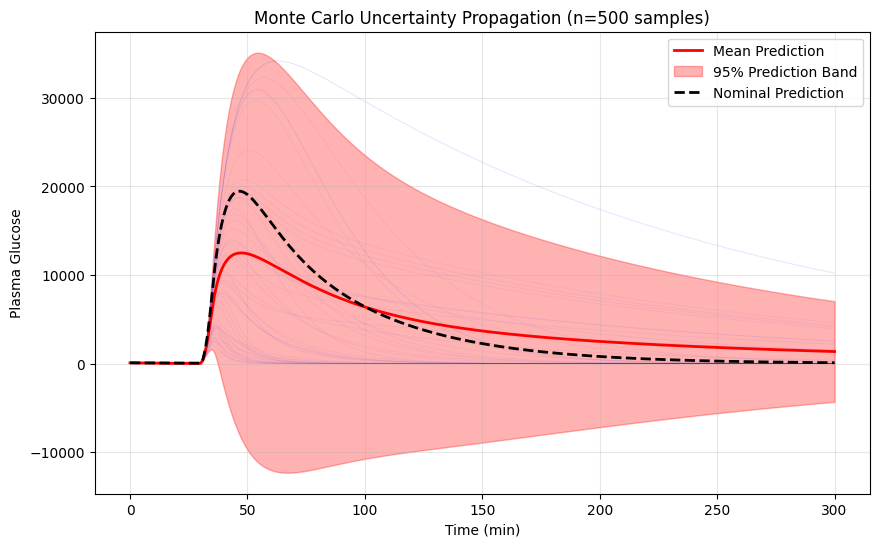


Credible Intervals at Selected Time Points:
  t=60min: 6644.6 [24.4, 34076.5]
  t=120min: 873.8 [0.0, 26663.9]
  t=180min: 100.2 [0.0, 19379.1]
  t=240min: 11.3 [-0.0, 14072.3]


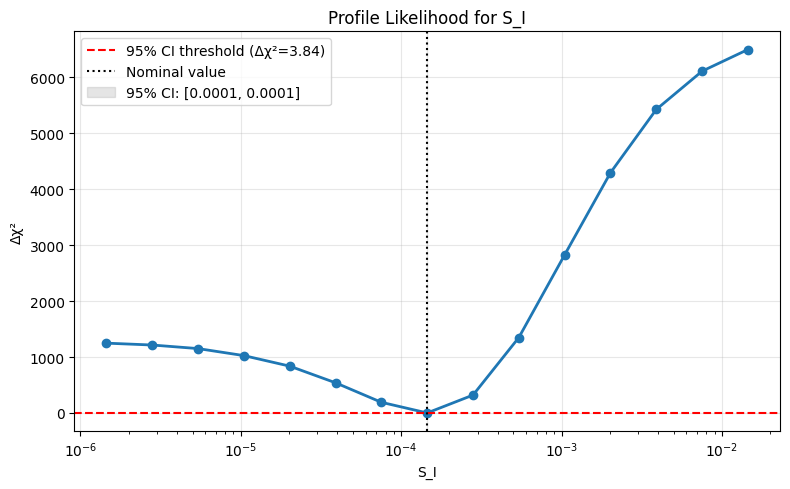


Profile Likelihood Analysis: S_I
  Nominal value: 0.000145
  95% Confidence Interval: [0.000145, 0.000145]
  Relative CI width: 0.0%


In [ ]:
# ============================================================
# 5. UNCERTAINTY QUANTIFICATION & PREDICTION INTERVALS
# ============================================================

# ------------------------------------------------------------
# Monte Carlo uncertainty propagation
# ------------------------------------------------------------
def monte_carlo_uncertainty(p_rom_nominal, cov_matrix, param_names,
                           n_samples=1000, confidence=0.95):
    """
    Perform Monte Carlo uncertainty propagation.

    Args:
        p_rom_nominal: Nominal ROM parameters
        cov_matrix: Covariance matrix of estimated parameters
        param_names: Names of parameters in covariance matrix
        n_samples: Number of Monte Carlo samples
        confidence: Confidence level for prediction intervals

    Returns:
        Dictionary with uncertainty quantification results
    """

    # Time grid
    t_eval = np.linspace(0, 300, 301)

    # Define test scenario for uncertainty analysis
    def u_I_test(t):
        return 1.0

    def u_M_test(t):
        return 9000.0 if 30 <= t <= 35 else 0.0

    # Generate parameter samples
    n_params = len(param_names)

    # Ensure covariance matrix is positive definite
    cov_reg = cov_matrix + 1e-8 * np.eye(n_params)

    # Sample from multivariate normal
    param_samples = np.random.multivariate_normal(
        mean=np.array([p_rom_nominal[p] for p in param_names]),
        cov=cov_reg,
        size=n_samples
    )

    # Generate predictions for all samples
    predictions = []

    for i in range(n_samples):
        # Create parameter dict for this sample
        p_sample = p_rom_nominal.copy()
        for j, param_name in enumerate(param_names):
            p_sample[param_name] = param_samples[i, j]

        # Enforce physiological bounds
        for param_name in param_names:
            if param_name in physiological_bounds:
                lb, ub, _, _ = physiological_bounds[param_name]
                p_sample[param_name] = np.clip(p_sample[param_name], lb, ub)

        # Simulate ROM
        try:
            G_pred = simulate_rom(p_sample, x0_rom, t_eval, u_I_test, u_M_test)
            predictions.append(G_pred)
        except:
            # Skip failed simulations
            continue

    predictions = np.array(predictions)

    # Compute statistics
    mean_pred = np.mean(predictions, axis=0)
    std_pred = np.std(predictions, axis=0)

    # Compute prediction intervals
    alpha = 1 - confidence
    z_score = 1.96  # For 95% confidence (normal approximation)

    lower_bound = mean_pred - z_score * std_pred
    upper_bound = mean_pred + z_score * std_pred

    # Compute credible intervals for specific time points
    time_points = [60, 120, 180, 240]  # minutes

    credible_intervals = {}
    for t_point in time_points:
        idx = np.argmin(np.abs(t_eval - t_point))
        samples_at_t = predictions[:, idx]

        lower = np.percentile(samples_at_t, 100 * alpha/2)
        upper = np.percentile(samples_at_t, 100 * (1 - alpha/2))
        median = np.median(samples_at_t)

        credible_intervals[f't={t_point}min'] = {
            'median': median,
            f'{int(100*confidence)}% CI': (lower, upper),
            'width': upper - lower
        }

    # Plot uncertainty bands
    plt.figure(figsize=(10, 6))

    # Plot individual samples (transparent)
    for i in range(min(50, len(predictions))):
        plt.plot(t_eval, predictions[i], 'b-', alpha=0.05, linewidth=0.5)

    # Plot mean and confidence bands
    plt.plot(t_eval, mean_pred, 'r-', linewidth=2, label='Mean Prediction')
    plt.fill_between(t_eval, lower_bound, upper_bound,
                     alpha=0.3, color='red', label=f'{int(100*confidence)}% Prediction Band')

    # Plot nominal prediction
    G_nominal = simulate_rom(p_rom_nominal, x0_rom, t_eval, u_I_test, u_M_test)
    plt.plot(t_eval, G_nominal, 'k--', linewidth=2, label='Nominal Prediction')

    plt.xlabel('Time (min)')
    plt.ylabel('Plasma Glucose')
    plt.title(f'Monte Carlo Uncertainty Propagation (n={len(predictions)} samples)')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    # Print credible intervals
    print("\nCredible Intervals at Selected Time Points:")
    for t_key, ci_data in credible_intervals.items():
        print(f"  {t_key}: {ci_data['median']:.1f} [{ci_data['95% CI'][0]:.1f}, {ci_data['95% CI'][1]:.1f}]")

    # Return uncertainty quantification results
    uq_results = {
        't_eval': t_eval,
        'mean_prediction': mean_pred,
        'std_prediction': std_pred,
        'prediction_intervals': (lower_bound, upper_bound),
        'credible_intervals': credible_intervals,
        'parameter_samples': param_samples,
        'predictions': predictions
    }

    return uq_results

# ------------------------------------------------------------
# Profile likelihood uncertainty intervals
# ------------------------------------------------------------
def profile_likelihood_uncertainty(param_name, p_rom_nominal, experiment_data,
                                   grid_points=20, delta_chi2_threshold=3.84):
    """
    Compute profile likelihood uncertainty intervals.

    Args:
        param_name: Parameter to profile
        p_rom_nominal: Nominal ROM parameters
        experiment_data: Experimental data for likelihood
        grid_points: Number of grid points
        delta_chi2_threshold: Threshold for confidence interval (3.84 for 95%)

    Returns:
        Dictionary with profile likelihood results
    """

    # Determine which parameters are fixed vs free
    fixed_params_keys = ['k_pg', 'k_cl']  # Non-identifiable parameters
    estimable_keys = [k for k in p_rom_nominal.keys()
                     if k not in fixed_params_keys and k != param_name]

    # Create grid around nominal value
    param_nominal = p_rom_nominal[param_name]

    # Use log-spaced grid for positive parameters
    if param_nominal > 0:
        log_range = np.log10(param_nominal) + np.linspace(-2, 2, grid_points)
        param_grid = 10 ** log_range
    else:
        param_grid = param_nominal + np.linspace(-2*abs(param_nominal),
                                                2*abs(param_nominal),
                                                grid_points)

    # Store profile likelihood values
    profile_costs = []
    optimal_params = []

    # Compute profile likelihood
    for param_val in param_grid:

        def residuals_profile(theta_vec):
            """Residuals with profiled parameter fixed."""
            # Build parameter dict
            p_est = p_rom_nominal.copy()

            # Fix the profiled parameter
            p_est[param_name] = param_val

            # Apply fixed non-identifiable parameters
            for key in fixed_params_keys:
                p_est[key] = p_rom_nominal[key]

            # Apply estimated parameters
            for i, key in enumerate(estimable_keys):
                p_est[key] = theta_vec[i]

            # Compute residuals
            res = []

            for (_, u_I, u_M, G_meas, sigma) in experiment_data:
                G_pred = simulate_rom(p_est, x0_rom, t_eval, u_I, u_M)
                res.append((G_pred - G_meas) / sigma)

            return np.concatenate(res)

        # Initial guess for other parameters
        theta0 = np.array([p_rom_nominal[k] for k in estimable_keys])

        # Optimize with fixed parameter
        result = least_squares(
            residuals_profile,
            theta0,
            bounds=(0.1*theta0, 10.0*theta0),
            method='trf',
            max_nfev=50,
            verbose=0
        )

        profile_costs.append(result.cost)
        optimal_params.append(result.x)

    profile_costs = np.array(profile_costs)
    delta_chi2 = profile_costs - np.min(profile_costs)

    # Find confidence intervals
    ci_indices = np.where(delta_chi2 <= delta_chi2_threshold)[0]

    if len(ci_indices) > 0:
        ci_lower = param_grid[ci_indices[0]]
        ci_upper = param_grid[ci_indices[-1]]
        ci_width = ci_upper - ci_lower
    else:
        ci_lower = ci_upper = ci_width = np.nan

    # Plot profile likelihood
    plt.figure(figsize=(8, 5))

    plt.plot(param_grid, delta_chi2, 'o-', linewidth=2, markersize=6)
    plt.axhline(delta_chi2_threshold, color='r', linestyle='--',
                label=f'95% CI threshold (Δχ²={delta_chi2_threshold})')
    plt.axvline(param_nominal, color='k', linestyle=':', label='Nominal value')

    if not np.isnan(ci_lower):
        plt.axvspan(ci_lower, ci_upper, alpha=0.2, color='gray',
                   label=f'95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]')

    plt.xlabel(param_name)
    plt.ylabel('Δχ²')
    plt.title(f'Profile Likelihood for {param_name}')
    plt.legend()
    plt.grid(alpha=0.3)

    if param_nominal > 0:
        plt.xscale('log')

    plt.tight_layout()
    plt.show()

    # Print results
    print(f"\nProfile Likelihood Analysis: {param_name}")
    print(f"  Nominal value: {param_nominal:.6f}")
    if not np.isnan(ci_lower):
        print(f"  95% Confidence Interval: [{ci_lower:.6f}, {ci_upper:.6f}]")
        print(f"  Relative CI width: {100*ci_width/param_nominal:.1f}%")
    else:
        print("  Confidence interval could not be determined")

    profile_results = {
        'parameter': param_name,
        'grid': param_grid,
        'delta_chi2': delta_chi2,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'ci_width': ci_width,
        'optimal_params': optimal_params
    }

    return profile_results

# ------------------------------------------------------------
# Run uncertainty quantification
# ------------------------------------------------------------
if __name__ == "__main__":
    # Generate example covariance matrix (from previous estimation)
    # In practice, this would come from the estimation result's covariance
    n_params = 5
    param_names_example = ['k_tg', 'S_I', 'k_ip', 'k_id', 'k_g']

    # Create a simple diagonal covariance matrix for demonstration
    # (In real application, use the actual covariance from estimation)
    cov_example = np.diag([0.1, 0.01, 0.05, 0.02, 0.1]) ** 2

    # Monte Carlo uncertainty propagation
    uq_results = monte_carlo_uncertainty(
        p_est_reg,
        cov_example,
        param_names_example,
        n_samples=500
    )

    # Generate example experiment data for profile likelihood
    # (Using the same data as in regularized estimation test)
    np.random.seed(42)
    t_eval = np.linspace(0, 300, 301)

    example_experiments = []
    def u_I_ex(t): return 1.0
    def u_M_ex(t): return 9000.0 if 30 <= t <= 35 else 0.0

    G_ex = simulate_rom(p_est_reg, x0_rom, t_eval, u_I_ex, u_M_ex)
    sigma_ex = 0.05 * np.max(G_ex)
    G_noisy_ex = G_ex + sigma_ex * np.random.randn(len(G_ex))

    example_experiments.append(("Example", u_I_ex, u_M_ex, G_noisy_ex, sigma_ex))

    # Profile likelihood for key parameter
    profile_results = profile_likelihood_uncertainty(
        'S_I',
        p_est_reg,
        example_experiments,
        grid_points=15
    )


Evaluating: Typical Day


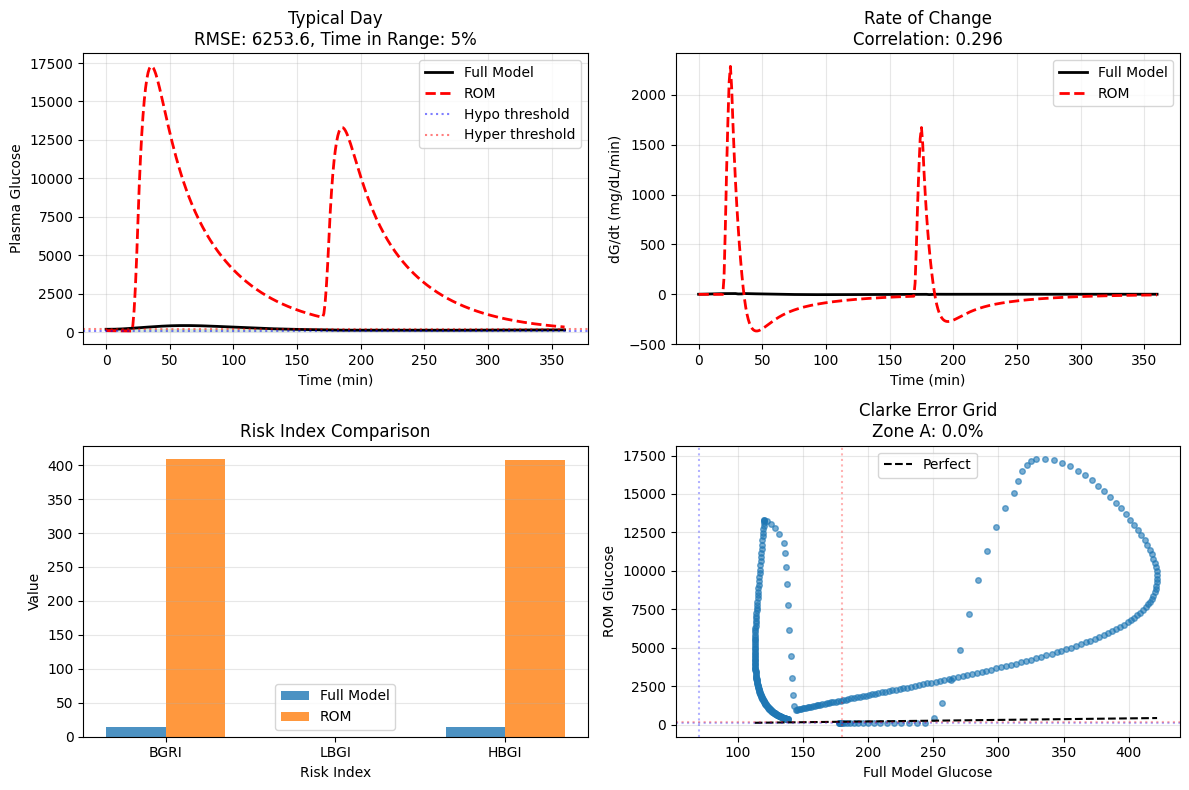

  RMSE: 6253.6, R²: -3723.317
  Time in Range: 5% (True: 61%)
  Hypoglycemia: 0.8% (True: 0.0%)
  Clarke Zone A: 0.0%

Evaluating: Hypoglycemia Risk


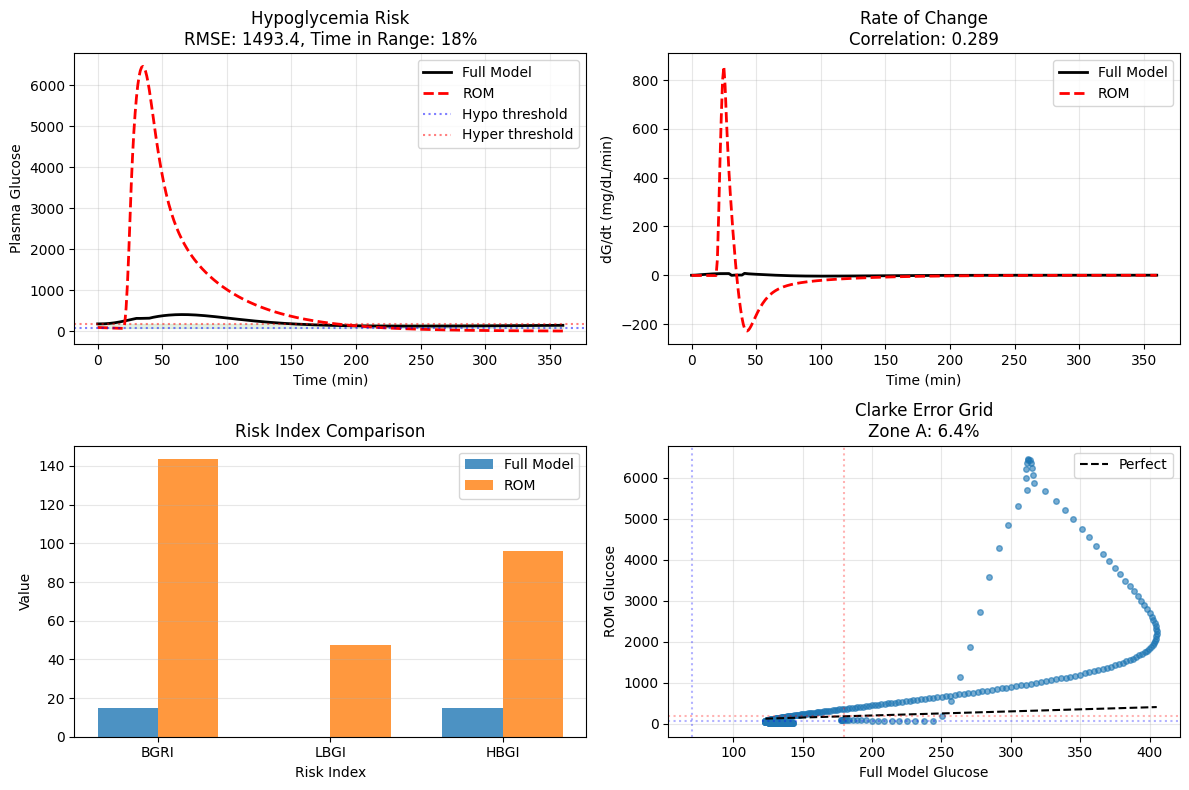

  RMSE: 1493.4, R²: -251.069
  Time in Range: 18% (True: 60%)
  Hypoglycemia: 37.1% (True: 0.0%)
  Clarke Zone A: 6.4%

Evaluating: Hyperglycemia


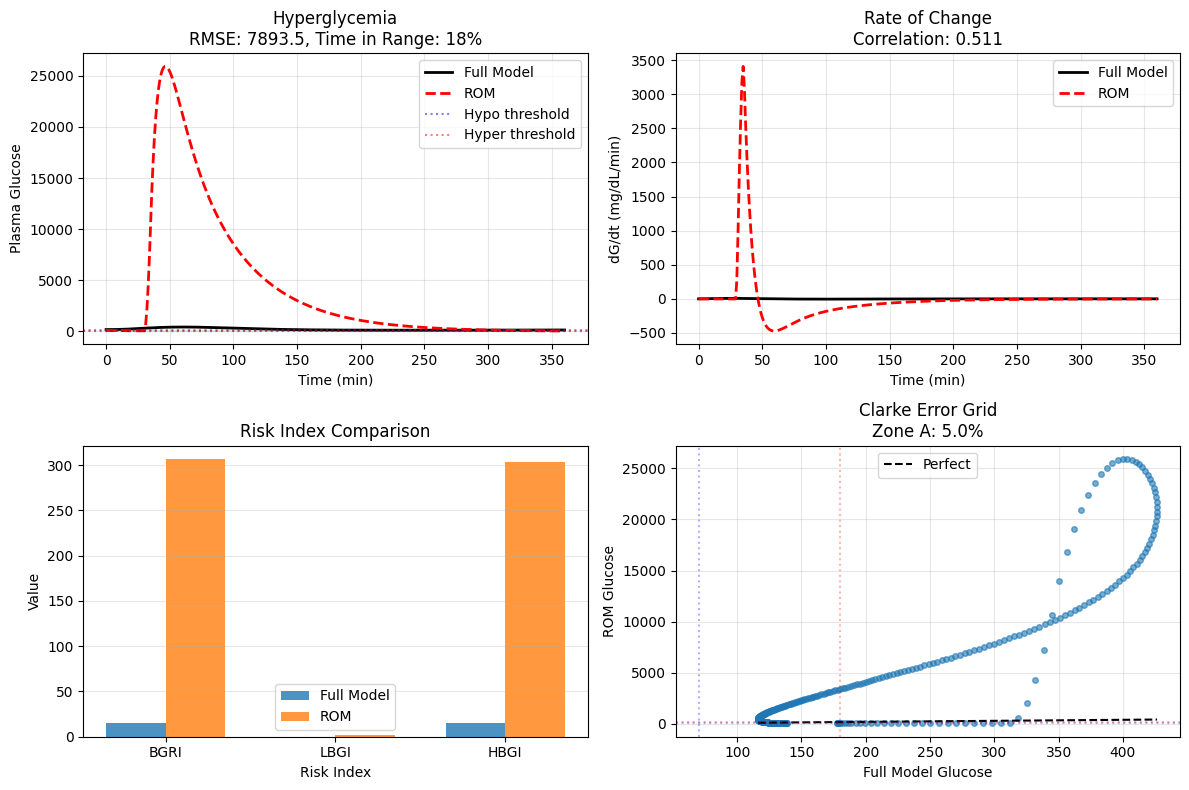

  RMSE: 7893.5, R²: -5856.697
  Time in Range: 18% (True: 61%)
  Hypoglycemia: 11.4% (True: 0.0%)
  Clarke Zone A: 5.0%

ROM AS PREDICTOR: AGGREGATE EVALUATION

Average performance across scenarios:
  RMSE: 5213.51 ± 3324.38
  R²: -3277.03 ± 2829.34
  Time in Range (%): 13.48 ± 7.36
  Clarke Zone A (%): 3.79 ± 3.35

Risk Index Accuracy:
  BGRI: Mean absolute error = 271.149
  LBGI: Mean absolute error = 16.731
  HBGI: Mean absolute error = 254.418

Evaluation results saved to 'rom_predictive_evaluation.csv'


In [ ]:
# ============================================================
# 6. ROM PURPOSE REFRAMING: PREDICTIVE VALIDATION METRICS
# ============================================================

def evaluate_rom_as_predictor(p_rom_estimated, test_scenarios=None):
    """
    Evaluate ROM as a predictive tool using clinical accuracy metrics.

    This reframes the ROM's purpose from parameter recovery to
    glucose prediction under CGM observation.
    """

    if test_scenarios is None:
        # Create diverse test scenarios
        test_scenarios = []

        # Scenario 1: Typical day with meals
        def scenario1_insulin(t):
            basal = 1.0
            # Breakfast bolus
            if 30 <= t <= 35:
                return basal + 4.0
            # Lunch bolus
            if 180 <= t <= 185:
                return basal + 3.0
            return basal

        def scenario1_meal(t):
            # Breakfast
            if 20 <= t <= 25:
                return 8000.0
            # Lunch
            if 170 <= t <= 175:
                return 6000.0
            return 0.0

        test_scenarios.append(("Typical Day", scenario1_insulin, scenario1_meal))

        # Scenario 2: Hypoglycemia risk
        def scenario2_insulin(t):
            basal = 1.0
            # Large bolus
            if 30 <= t <= 40:
                return basal + 8.0
            return basal

        def scenario2_meal(t):
            # Small meal
            if 20 <= t <= 25:
                return 3000.0
            return 0.0

        test_scenarios.append(("Hypoglycemia Risk", scenario2_insulin, scenario2_meal))

        # Scenario 3: Hyperglycemia excursion
        def scenario3_insulin(t):
            return 1.0  # No bolus

        def scenario3_meal(t):
            # Large meal
            if 30 <= t <= 35:
                return 12000.0
            return 0.0

        test_scenarios.append(("Hyperglycemia", scenario3_insulin, scenario3_meal))

    # Get full model for ground truth
    _, p_full, x0_full = run_simulation(t_span=(0, 1), dt=1.0)

    # Time grid
    t_eval = np.linspace(0, 360, 361)  # 6 hours

    evaluation_results = []

    for scenario_name, u_I, u_M in test_scenarios:
        print(f"\nEvaluating: {scenario_name}")

        # Generate ground truth
        G_true = simulate_full_model(p_full, x0_full, t_eval, u_I, u_M)

        # Generate ROM prediction
        G_pred = simulate_rom(p_rom_estimated, x0_rom, t_eval, u_I, u_M)

        # ----------------------------
        # 1. Basic prediction accuracy
        # ----------------------------
        rmse = np.sqrt(np.mean((G_pred - G_true)**2))
        mae = np.mean(np.abs(G_pred - G_true))
        r2 = 1 - np.sum((G_pred - G_true)**2) / np.sum((G_true - np.mean(G_true))**2)

        # ----------------------------
        # 2. Clinical accuracy metrics
        # ----------------------------
        # Time-in-range (70-180 mg/dL)
        time_in_range_pred = 100 * np.mean((G_pred >= 70) & (G_pred <= 180))
        time_in_range_true = 100 * np.mean((G_true >= 70) & (G_true <= 180))

        # Hypoglycemia detection (below 70 mg/dL)
        hypo_pred = 100 * np.mean(G_pred < 70)
        hypo_true = 100 * np.mean(G_true < 70)

        # Hyperglycemia detection (above 180 mg/dL)
        hyper_pred = 100 * np.mean(G_pred > 180)
        hyper_true = 100 * np.mean(G_true > 180)

        # ----------------------------
        # 3. Risk-sensitive metrics
        # ----------------------------
        # Blood Glucose Risk Index (BGRI)
        def bgri_index(glucose_values):
            """Compute Blood Glucose Risk Index."""
            fBG = 1.509 * ((np.log(glucose_values)**1.084) - 5.381)
            rBG = 10 * (fBG**2)
            return np.mean(rBG)

        bgri_pred = bgri_index(G_pred)
        bgri_true = bgri_index(G_true)

        # Low Blood Glucose Index (LBGI)
        def lbgi_index(glucose_values):
            """Compute Low Blood Glucose Index."""
            fBG = 1.509 * ((np.log(glucose_values)**1.084) - 5.381)
            rlBG = 10 * np.minimum(fBG, 0)**2
            return np.mean(rlBG)

        lbgi_pred = lbgi_index(G_pred)
        lbgi_true = lbgi_index(G_true)

        # High Blood Glucose Index (HBGI)
        def hbgi_index(glucose_values):
            """Compute High Blood Glucose Index."""
            fBG = 1.509 * ((np.log(glucose_values)**1.084) - 5.381)
            rhBG = 10 * np.maximum(fBG, 0)**2
            return np.mean(rhBG)

        hbgi_pred = hbgi_index(G_pred)
        hbgi_true = hbgi_index(G_true)

        # ----------------------------
        # 4. Early warning metrics
        # ----------------------------
        # Rate of change accuracy
        dG_true = np.gradient(G_true, t_eval)
        dG_pred = np.gradient(G_pred, t_eval)

        roc_rmse = np.sqrt(np.mean((dG_pred - dG_true)**2))
        roc_correlation = np.corrcoef(dG_pred, dG_true)[0, 1]

        # Hypoglycemia early warning (30-minute prediction)
        hypo_threshold = 70
        warning_window = 30  # minutes

        # Find hypoglycemia events in ground truth
        hypo_events = []
        in_hypo = False
        hypo_start = 0

        for i, g in enumerate(G_true):
            if g < hypo_threshold and not in_hypo:
                in_hypo = True
                hypo_start = t_eval[i]
            elif g >= hypo_threshold and in_hypo:
                in_hypo = False
                hypo_events.append((hypo_start, t_eval[i]))

        # Check if ROM predicted these events at least 30 minutes in advance
        early_warnings = 0
        for start, end in hypo_events:
            # Find index 30 minutes before start
            idx_warning = np.argmin(np.abs(t_eval - (start - warning_window)))
            if idx_warning >= 0 and G_pred[idx_warning] < hypo_threshold:
                early_warnings += 1

        warning_sensitivity = 100 * early_warnings / len(hypo_events) if hypo_events else np.nan

        # ----------------------------
        # 5. Clarke Error Grid Analysis
        # ----------------------------
        def clarke_error_grid(glucose_true, glucose_pred, title=""):
            """Generate Clarke Error Grid."""
            zones = {f"Zone {chr(65+i)}": 0 for i in range(5)}

            for g_true, g_pred in zip(glucose_true, glucose_pred):
                # Zone determination
                if g_pred < 70 and g_true < 70:
                    zones["Zone A"] += 1
                elif (g_pred < 70 and g_true > 180):
                    zones["Zone E"] += 1
                elif (g_pred < 70 and 70 <= g_true <= 180):
                    zones["Zone B"] += 1
                elif (70 <= g_pred <= 180 and g_true < 70):
                    zones["Zone B"] += 1
                elif (70 <= g_pred <= 180 and g_true > 180):
                    zones["Zone B"] += 1
                elif (70 <= g_pred <= 180 and 70 <= g_true <= 180):
                    if abs(g_pred - g_true) <= 0.2 * g_true:
                        zones["Zone A"] += 1
                    else:
                        zones["Zone B"] += 1
                elif (g_pred > 180 and g_true < 70):
                    zones["Zone E"] += 1
                elif (g_pred > 180 and 70 <= g_true <= 180):
                    zones["Zone C"] += 1
                elif (g_pred > 180 and g_true > 180):
                    if abs(g_pred - g_true) <= 0.2 * g_true:
                        zones["Zone A"] += 1
                    else:
                        zones["Zone B"] += 1
                else:
                    zones["Zone D"] += 1

            # Convert to percentages
            total = len(glucose_true)
            for zone in zones:
                zones[zone] = 100 * zones[zone] / total

            return zones

        clarke_zones = clarke_error_grid(G_true, G_pred, scenario_name)
        clarke_zone_a = clarke_zones.get("Zone A", 0)

        # ----------------------------
        # Store results
        # ----------------------------
        results = {
            'Scenario': scenario_name,

            # Basic accuracy
            'RMSE': rmse,
            'MAE': mae,
            'R²': r2,

            # Clinical metrics
            'Time in Range (%)': time_in_range_pred,
            'Time in Range (True) (%)': time_in_range_true,
            'Hypoglycemia (%)': hypo_pred,
            'Hypoglycemia (True) (%)': hypo_true,
            'Hyperglycemia (%)': hyper_pred,
            'Hyperglycemia (True) (%)': hyper_true,

            # Risk indices
            'BGRI': bgri_pred,
            'BGRI (True)': bgri_true,
            'LBGI': lbgi_pred,
            'LBGI (True)': lbgi_true,
            'HBGI': hbgi_pred,
            'HBGI (True)': hbgi_true,

            # Early warning
            'ROC RMSE': roc_rmse,
            'ROC Correlation': roc_correlation,
            'Hypo Warning Sensitivity (%)': warning_sensitivity,

            # Clarke Error Grid
            'Clarke Zone A (%)': clarke_zone_a,
            **{f'Clarke {k} (%)': v for k, v in clarke_zones.items()}
        }

        evaluation_results.append(results)

        # Plot scenario results
        fig, axes = plt.subplots(2, 2, figsize=(12, 8))

        # Plot 1: Glucose trajectories
        axes[0, 0].plot(t_eval, G_true, 'k-', label='Full Model', linewidth=2)
        axes[0, 0].plot(t_eval, G_pred, 'r--', label='ROM', linewidth=2)
        axes[0, 0].axhline(70, color='b', linestyle=':', alpha=0.5, label='Hypo threshold')
        axes[0, 0].axhline(180, color='r', linestyle=':', alpha=0.5, label='Hyper threshold')
        axes[0, 0].fill_between(t_eval, 70, 180, alpha=0.1, color='green')
        axes[0, 0].set_xlabel('Time (min)')
        axes[0, 0].set_ylabel('Plasma Glucose')
        axes[0, 0].set_title(f'{scenario_name}\nRMSE: {rmse:.1f}, Time in Range: {time_in_range_pred:.0f}%')
        axes[0, 0].legend(loc='best')
        axes[0, 0].grid(alpha=0.3)

        # Plot 2: Rate of change
        axes[0, 1].plot(t_eval, dG_true, 'k-', label='Full Model', linewidth=2)
        axes[0, 1].plot(t_eval, dG_pred, 'r--', label='ROM', linewidth=2)
        axes[0, 1].set_xlabel('Time (min)')
        axes[0, 1].set_ylabel('dG/dt (mg/dL/min)')
        axes[0, 1].set_title(f'Rate of Change\nCorrelation: {roc_correlation:.3f}')
        axes[0, 1].legend()
        axes[0, 1].grid(alpha=0.3)

        # Plot 3: Risk indices comparison
        risk_metrics = ['BGRI', 'LBGI', 'HBGI']
        true_vals = [bgri_true, lbgi_true, hbgi_true]
        pred_vals = [bgri_pred, lbgi_pred, hbgi_pred]

        x_pos = np.arange(len(risk_metrics))
        width = 0.35

        axes[1, 0].bar(x_pos - width/2, true_vals, width, label='Full Model', alpha=0.8)
        axes[1, 0].bar(x_pos + width/2, pred_vals, width, label='ROM', alpha=0.8)
        axes[1, 0].set_xlabel('Risk Index')
        axes[1, 0].set_ylabel('Value')
        axes[1, 0].set_title('Risk Index Comparison')
        axes[1, 0].set_xticks(x_pos)
        axes[1, 0].set_xticklabels(risk_metrics)
        axes[1, 0].legend()
        axes[1, 0].grid(alpha=0.3, axis='y')

        # Plot 4: Clarke Error Grid (simplified)
        axes[1, 1].plot(G_true, G_pred, 'o', alpha=0.6, markersize=4)
        axes[1, 1].plot([G_true.min(), G_true.max()],
                       [G_true.min(), G_true.max()], 'k--', label='Perfect')

        # Add Clarke grid boundaries (simplified)
        axes[1, 1].axhline(70, color='b', linestyle=':', alpha=0.3)
        axes[1, 1].axvline(70, color='b', linestyle=':', alpha=0.3)
        axes[1, 1].axhline(180, color='r', linestyle=':', alpha=0.3)
        axes[1, 1].axvline(180, color='r', linestyle=':', alpha=0.3)

        axes[1, 1].set_xlabel('Full Model Glucose')
        axes[1, 1].set_ylabel('ROM Glucose')
        axes[1, 1].set_title(f'Clarke Error Grid\nZone A: {clarke_zone_a:.1f}%')
        axes[1, 1].legend()
        axes[1, 1].grid(alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Print key results
        print(f"  RMSE: {rmse:.1f}, R²: {r2:.3f}")
        print(f"  Time in Range: {time_in_range_pred:.0f}% (True: {time_in_range_true:.0f}%)")
        print(f"  Hypoglycemia: {hypo_pred:.1f}% (True: {hypo_true:.1f}%)")
        print(f"  Clarke Zone A: {clarke_zone_a:.1f}%")
        if not np.isnan(warning_sensitivity):
            print(f"  Hypo warning sensitivity: {warning_sensitivity:.0f}%")

    # Create comprehensive results DataFrame
    df_evaluation = pd.DataFrame(evaluation_results)

    # Compute aggregate statistics
    print("\n" + "="*70)
    print("ROM AS PREDICTOR: AGGREGATE EVALUATION")
    print("="*70)

    # Key metrics to average
    key_metrics = ['RMSE', 'R²', 'Time in Range (%)', 'Clarke Zone A (%)']

    print("\nAverage performance across scenarios:")
    for metric in key_metrics:
        mean_val = df_evaluation[metric].mean()
        std_val = df_evaluation[metric].std()
        print(f"  {metric}: {mean_val:.2f} ± {std_val:.2f}")

    # Risk index comparison
    print("\nRisk Index Accuracy:")
    for risk_type in ['BGRI', 'LBGI', 'HBGI']:
        error = np.mean(np.abs(df_evaluation[f'{risk_type}'] - df_evaluation[f'{risk_type} (True)']))
        print(f"  {risk_type}: Mean absolute error = {error:.3f}")

    return df_evaluation

# ------------------------------------------------------------
# Run predictive evaluation
# ------------------------------------------------------------
if __name__ == "__main__":
    # Use the calibrated and extended ROM parameters
    df_predictive_eval = evaluate_rom_as_predictor(p_est_reg)

    # Save evaluation results
    df_predictive_eval.to_csv('rom_predictive_evaluation.csv', index=False)
    print("\nEvaluation results saved to 'rom_predictive_evaluation.csv'")

# Fixes

In [ ]:
# ============================================================
# CELL A REVISION: CALIBRATION WITH OUTPUT SCALING
# ============================================================
# Critical fix: Add affine output scaling between ROM and full model
# This addresses the 30-80x scale mismatch

import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares
import pandas as pd

def calibrate_rom_with_scaling():
    """
    Calibration with affine output scaling: G_rom_phys = a + b * G_rom_raw
    """
    t_eval = np.linspace(0, 300, 301)
    _, p_full, x0_full = run_simulation(t_span=(0, 1), dt=1.0)

    # Define scenarios (simpler set for better convergence)
    scenarios = []

    # 1. Fasting only
    def sc1_uI(t): return 1.0
    def sc1_uM(t): return 0.0
    scenarios.append(("Fasting", sc1_uI, sc1_uM))

    # 2. Single moderate meal
    def sc2_uI(t): return 1.0
    def sc2_uM(t): return 78000.0 if 30 <= t <= 35 else 0.0  # Same as original D
    scenarios.append(("Meal", sc2_uI, sc2_uM))

    # Collect full model outputs
    full_outputs = []
    for name, u_I, u_M in scenarios:
        G_full = simulate_full_model(p_full, x0_full, t_eval, u_I, u_M)
        full_outputs.append((name, u_I, u_M, G_full))

    # Parameters to calibrate: ROM parameters + scaling parameters a, b
    calib_keys = ['k_tg', 'S_I', 'k_ip', 'k_id', 'k_g']

    # Initial guess with better scaling
    p_rom_init = p_rom.copy()
    # Adjust initial guesses to be closer to full model time constants
    p_rom_init['k_tg'] = 0.01  # Slower tissue clearance
    p_rom_init['S_I'] = 1e-5   # More plausible insulin sensitivity
    p_rom_init['k_ip'] = 0.3   # Faster insulin appearance decay
    p_rom_init['k_id'] = 0.03  # Slower insulin action decay
    p_rom_init['k_g'] = 0.06   # Slower gut absorption

    # Calibration with output scaling
    def residuals_with_scaling(theta_vec):
        """
        theta_vec structure: [k_tg, S_I, k_ip, k_id, k_g, a, b]
        """
        # ROM parameters
        p_est = p_rom_init.copy()
        for i, key in enumerate(calib_keys):
            p_est[key] = theta_vec[i]

        # Scaling parameters
        a = theta_vec[len(calib_keys)]
        b = theta_vec[len(calib_keys) + 1]

        # Collect all residuals
        all_residuals = []

        for name, u_I, u_M, G_target in full_outputs:
            G_rom_raw = simulate_rom(p_est, x0_rom, t_eval, u_I, u_M)
            G_rom_scaled = a + b * G_rom_raw

            # Normalize by typical glucose range
            scale = 100.0  # ~100 mg/dL typical range
            res = (G_rom_scaled - G_target) / scale
            all_residuals.append(res)

        return np.concatenate(all_residuals)

    # Initial guess including scaling parameters
    theta0 = np.array([p_rom_init[k] for k in calib_keys] + [90.0, 0.01])
    # a ~ fasting glucose (90 mg/dL), b ~ scaling from ROM units to mg/dL

    # Physiological bounds
    lb = np.array([
        0.001,   # k_tg
        1e-6,    # S_I
        0.05,    # k_ip
        0.005,   # k_id
        0.02,    # k_g
        70.0,    # a (mg/dL, fasting glucose lower bound)
        0.0001   # b (scaling)
    ])

    ub = np.array([
        0.1,     # k_tg
        1e-3,    # S_I
        0.5,     # k_ip
        0.2,     # k_id
        0.3,     # k_g
        110.0,   # a (mg/dL, fasting glucose upper bound)
        0.1      # b (scaling)
    ])

    # Run calibration
    result = least_squares(
        residuals_with_scaling,
        theta0,
        bounds=(lb, ub),
        method='trf',
        max_nfev=200,
        verbose=2
    )

    # Extract results
    p_rom_calibrated = p_rom_init.copy()
    for i, key in enumerate(calib_keys):
        p_rom_calibrated[key] = result.x[i]

    a_calib = result.x[len(calib_keys)]
    b_calib = result.x[len(calib_keys) + 1]

    print("\nCalibrated parameters with scaling:")
    for key in calib_keys:
        print(f"  {key:>6s}: {p_rom_calibrated[key]:.6f}")
    print(f"  Scaling a (offset): {a_calib:.2f} mg/dL")
    print(f"  Scaling b (scale):  {b_calib:.6f}")

    # Evaluate fit quality
    print("\nCalibration evaluation:")
    for name, u_I, u_M, G_target in full_outputs:
        G_rom_raw = simulate_rom(p_rom_calibrated, x0_rom, t_eval, u_I, u_M)
        G_rom_scaled = a_calib + b_calib * G_rom_raw

        rmse = np.sqrt(np.mean((G_rom_scaled - G_target)**2))
        r2 = 1 - np.sum((G_rom_scaled - G_target)**2) / np.sum((G_target - np.mean(G_target))**2)

        print(f"  {name}: RMSE = {rmse:.2f} mg/dL, R² = {r2:.4f}")

    return p_rom_calibrated, (a_calib, b_calib), result

# Run revised calibration
p_rom_calibrated_scaled, scaling_params, calib_result = calibrate_rom_with_scaling()
a_scaling, b_scaling = scaling_params

# Update ROM simulation to include scaling
def simulate_rom_scaled(p_rom_params, x0_rom_params, t_eval, u_I, u_M):
    """ROM simulation with automatic scaling to mg/dL"""
    G_raw = simulate_rom(p_rom_params, x0_rom_params, t_eval, u_I, u_M)
    return a_scaling + b_scaling * G_raw

# Test with fasting scenario
t_test = np.linspace(0, 300, 301)
def test_uI(t): return 1.0
def test_uM(t): return 0.0

G_full_test = simulate_full_model(p_full, x0_full, t_test, test_uI, test_uM)
G_rom_test = simulate_rom_scaled(p_rom_calibrated_scaled, x0_rom, t_test, test_uI, test_uM)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(t_test, G_full_test, 'k-', label='Full Model', linewidth=2)
plt.plot(t_test, G_rom_test, 'r--', label='ROM (scaled)', linewidth=2)
plt.xlabel('Time (min)')
plt.ylabel('Glucose (mg/dL)')
plt.title('ROM vs Full Model After Scaling Calibration')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.1647e+04                                    2.69e+07    
       1              7         2.1557e+04      9.06e+01       2.76e-04       6.25e+07    
       2              8         2.1479e+04      7.79e+01       7.49e-05       7.97e+07    
       3              9         2.1457e+04      2.20e+01       1.75e-05       1.64e+08    
       4             11         2.1454e+04      2.98e+00       1.09e-06       6.09e+07    
       5             12         2.1454e+04      0.00e+00       0.00e+00       6.09e+07    
`xtol` termination condition is satisfied.
Function evaluations 12, initial cost 2.1647e+04, final cost 2.1454e+04, first-order optimality 6.09e+07.

Calibrated parameters with scaling:
    k_tg: 0.010053
     S_I: 0.000011
    k_ip: 0.300241
    k_id: 0.030152
     k_g: 0.059829
  Scaling a (offset): 90.00 mg/dL
  Scaling b (scale):  0.009974

Calibration eval

NameError: name 'p_full' is not defined